In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans
import imageio

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter, plot_N, TDR_axes, out_axes, make_FP_axs
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, comp_eig_decomp
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [3]:
model_n = 0
task_list = ['fdgo','fdanti','delaygo','delayanti']
task_list = hp['rule_trains']
rule = task_list[0]
which_net = 'l2w0001'
fldr = '4_tasks'
supp = []#'long_train'

if fldr == 'two_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
elif fldr == 'single_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net,rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
h_all,trial_all,tasks_all = make_h_trial_rule(m_all,mode = 'test',noise_on = False)

NameError: name 'hp' is not defined

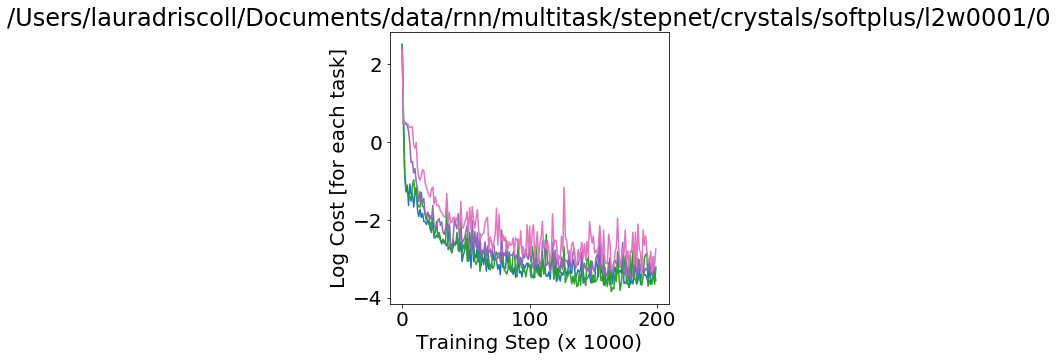

In [29]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('tab20')
for model_n in range(1):
    m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
    fname = os.path.join(m_all, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)
    for ri in range(len(task_list)):
        r = task_list[ri]
        c = cmap(ri/(len(task_list)+1))
        ax = fig.add_subplot(1,1,1)
        x = np.log(log_all['cost_'+r])
        plt.plot(x,'-',c = c)
        ax.set_xlabel('Training Step (x 1000)')
        ax.set_ylabel('Log Cost [for each task]')
    #     plt.ylim([-6,2])
    
    plt.title(m_all)
    plt.show()    

In [21]:
plt.rcParams.update({'font.size': 20})

model_n = 0
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
m = m_all
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    alpha = .2
    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

def load_fps(m_all,rule_in,fp_epoch,t_num_deg = 0):
    filename, _  = get_filename(trial_all[rule_in], fp_epoch, t_num_deg)
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,filename+'.npz')
    fp_struct = np.load(f)
    J_xstar = fp_struct['J_xstar']
    eig_decomps = comp_eig_decomp(J_xstar)
    sorted_fps = fp_struct['xstar']
    fp_inds = range(len(sorted_fps))

    return eig_decomps, sorted_fps, fp_inds, f

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [22]:
def fp_mov(m,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c_master = 'k',plot_other_trials = True):

    fldr = os.path.join(m,'fp_mov/')
    if not os.path.exists(fldr):
        os.makedirs(fldr)

    fig_title = rule_master+'_'+fp_epoch+'_'+str(t_num*4)
    movie_dir = os.path.join(fldr,fig_title)
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)
        
    cmap=plt.get_cmap('rainbow')
    epoch_name, rule_name, _, _ = take_names(fp_epoch,rule_master)

    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        
        trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
        T_inds = get_T_inds(trial,fp_epoch)
        movie_inds = range(0,n_steps)#T_inds[0:-1:2]

        mov_i = 0
        for im_num in movie_inds:
            fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
            ax = plt.subplot(111)
            for rule in rule_set:
                trial = generate_trials(rule, hparams, mode='test',noise_on=False)
                feed_dict = tools.gen_feed_dict(model, trial, hparams)
                h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
                T,S,N = np.shape(h_tf)
                T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

                if plot_other_trials==True:
                    for s in range(0,S,int(S/8)):

                        if c_master == 'y_locs':
                            c_inds = trial.y_loc[-1,:]
                            c = cmap(c_inds[s]/(2*np.pi))
                        elif c_master == 'x_locs':
                            stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
                            c = cmap(stim1_locs[s]/(2*np.pi))
                        else:
                            c = c_master

                        X_trial = np.dot(h_tf[T_inds,s,:],D_use)
                        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

            trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            if c_master == 'y_locs':
                c_inds = trial.y_loc[-1,:]
                c = cmap(c_inds[t_num]/(2*np.pi))
            elif c_master == 'x_locs':
                stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
                c = cmap(stim1_locs[t_num]/(2*np.pi))
            else:
                c = c_master

            for fp_ind in fp_inds:

                if np.max(eig_decomps[fp_ind]['evals'])>.99:
                    markerfacecolor = 'None'
                    
                else:
                    markerfacecolor = c

                    fp = np.dot(sorted_fps[fp_ind,:],D_use)
                    plt.plot(fp[0],fp[1],'o',c = c,linewidth = 5,markersize = 10,markerfacecolor = markerfacecolor)

            X_trial = np.dot(h_tf[T_inds,t_num,:],D_use)
            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = .8, linewidth = 5)
            
            plot_ind = np.min((im_num,len(T_inds)))

            plt.plot(X_trial[:plot_ind,0],X_trial[:plot_ind,1],linestyle,c = c, alpha = .8, linewidth = 3)
            plt.plot(X_trial[plot_ind-1,0],X_trial[plot_ind-1,1],'^',c = c, alpha = .8, linewidth = 3, markersize = 10)
            
            if im_num>len(T_inds):
                x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
                h_t = vanilla_run_with_h0(params, x_t, h_tf[T_inds[0],t_num,:], hparams)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[im_num-1,0],jitter[im_num-1,1],'^',c = c, alpha = .5, linewidth = 3, markersize = 10)
                plt.plot(jitter[:im_num,0],jitter[:im_num,1],'-',c = c,linewidth = 1)

            mov_i += 1 
            
            tit = rule_name
            plt.title(tit)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            
            
            if fp_epoch=='fix1':
                plt.ylim(-1,1)
                plt.xlim(-3,1)
            else:
                plt.ylim(-12,12)
                plt.xlim(-12,12)
                
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png')

    images = []
    for t in range(3,mov_i):#T*xt):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)


In [18]:
def jitter_mov(m,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c_master = 'k',plot_other_trials = True):

    fldr = os.path.join(m,'jitter_mov/')
    if not os.path.exists(fldr):
        os.makedirs(fldr)

    fig_title = rule_master+'_'+fp_epoch+'_'+str(t_num*4)
    movie_dir = os.path.join(fldr,fig_title)
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)
        
    cmap=plt.get_cmap('rainbow')
    epoch_name, rule_name, _, _ = take_names(fp_epoch,rule_master)
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        
        trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
        T_inds = get_T_inds(trial,fp_epoch)
        movie_inds = range(0,n_steps)#T_inds[0:-1:2]
        
        fp_jitters = {}
        for fp_ind in fp_inds:
            fp_jitters[fp_ind] = np.zeros((n_steps,n_jit,2))
            x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
            for jit in range(n_jit):
                h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(n_rnn)
                h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                jitter = np.dot(h_t,D_use)
                fp_jitters[fp_ind][:,jit,:] = jitter[1:,:2]

        mov_i = 0
        for im_num in movie_inds:
            fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
            ax = plt.subplot(111)
            for rule in rule_set:
                trial = generate_trials(rule, hparams, mode='test',noise_on=False)
                feed_dict = tools.gen_feed_dict(model, trial, hparams)
                h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
                T,S,N = np.shape(h_tf)
                T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

                if plot_other_trials==True:
                    for s in range(0,S,int(S/8)):

                        if c_master == 'y_locs':
                            c_inds = trial.y_loc[-1,:]
                            c = cmap(c_inds[s]/(2*np.pi))
                        elif c_master == 'x_locs':
                            stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
                            c = cmap(stim1_locs[s]/(2*np.pi))
                        else:
                            c = c_master

                        X_trial = np.dot(h_tf[T_inds,s,:],D_use)
                        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

            trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            if c_master == 'y_locs':
                c_inds = trial.y_loc[-1,:]
                c = cmap(c_inds[t_num]/(2*np.pi))
            elif c_master == 'x_locs':
                stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
                c = cmap(stim1_locs[t_num]/(2*np.pi))
            else:
                c = c_master

            X_trial = np.dot(h_tf[T_inds,t_num,:],D_use)
            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = .8, linewidth = 5)
            
            plot_ind = np.min((im_num,len(T_inds)))

            plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = .8, linewidth = 3)
            plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = .8, linewidth = 3, markersize = 10)
            
            x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
            h_t = vanilla_run_with_h0(params, x_t, h_tf[T_inds[0],t_num,:], hparams)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c, alpha = .5, linewidth = 3, markersize = 10)
            plt.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = 1)
            

            for fp_ind in fp_inds:

                if np.max(eig_decomps[fp_ind]['evals'])>.99:
                    markerfacecolor = 'None'
                    
                else:
                    markerfacecolor = c

                    plt.plot(fp_jitters[fp_ind][im_num,:,0],fp_jitters[fp_ind][im_num,:,1],'^k',linewidth = .1,alpha = .1)
                    plt.plot(fp_jitters[fp_ind][:im_num,:,0],fp_jitters[fp_ind][:im_num,:,1],'-k',linewidth = .1)

                    fp = np.dot(sorted_fps[fp_ind,:],D_use)
                    plt.plot(fp[0],fp[1],'o',c = c,linewidth = 5,markersize = 10,markerfacecolor = markerfacecolor)

            mov_i += 1 

            tit = rule_name
            plt.title(tit)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            
            if fp_epoch=='fix1':
                plt.ylim(-1,1)
                plt.xlim(-3,1)
            else:
                plt.ylim(-12,12)
                plt.xlim(-12,12)
                
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png')

    images = []
    for t in range(1,mov_i):#T*xt):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)

In [19]:
# eig_decomps, sorted_fps, fp_inds, f = load_fps(m_all,task_list[0],'stim1',t_num_deg = 0)
# D_use, _, _ = make_FP_axs(f,m_all,task_list[0],'stim1',axs = 'pca')

In [7]:
# model_n = 0
# m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

In [13]:
# print(trial)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


delay1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


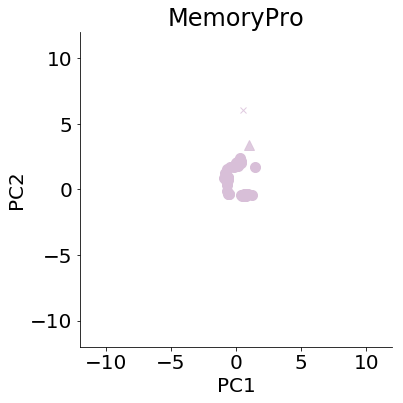

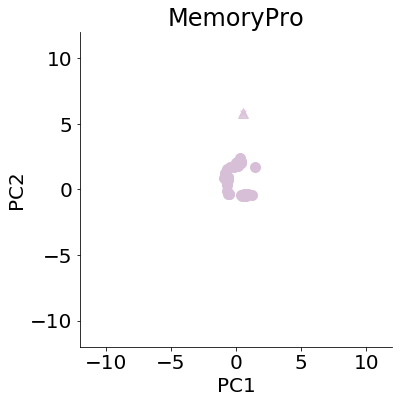

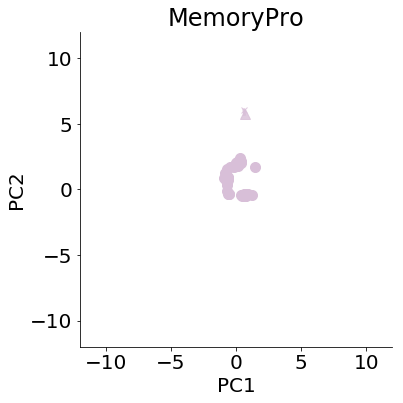

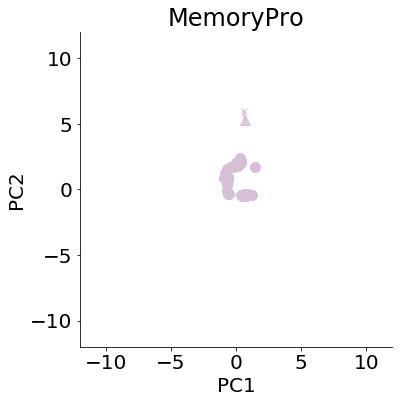

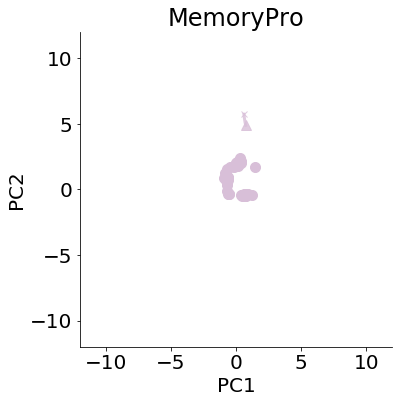

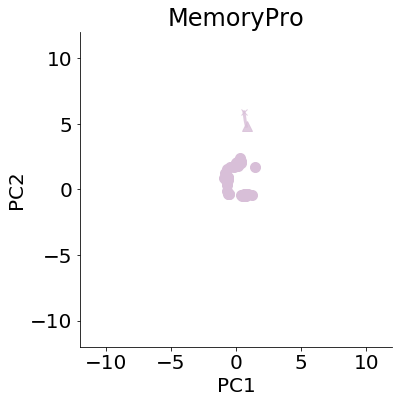

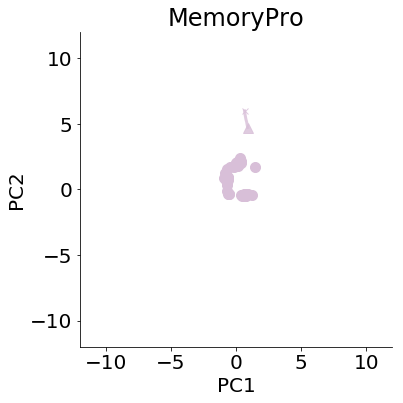

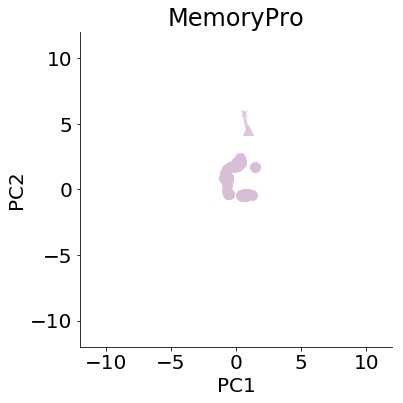

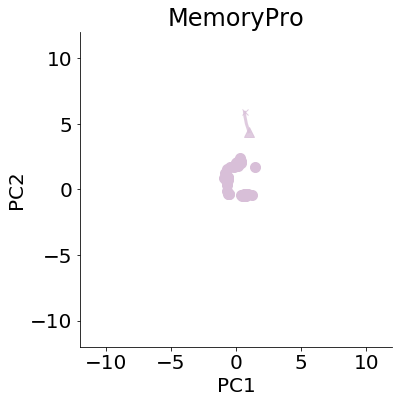

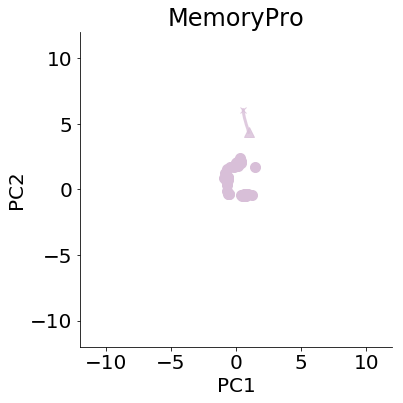

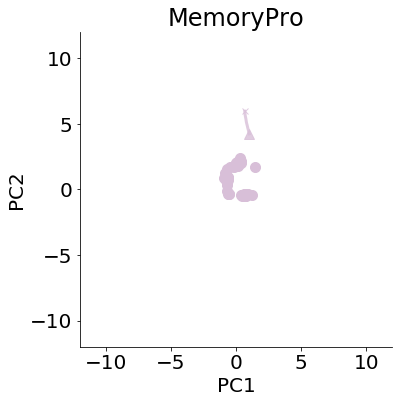

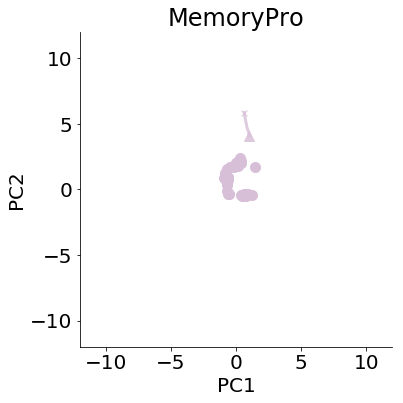

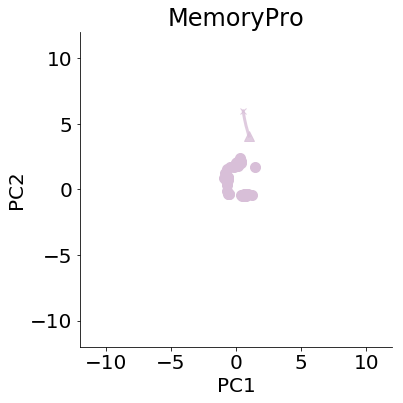

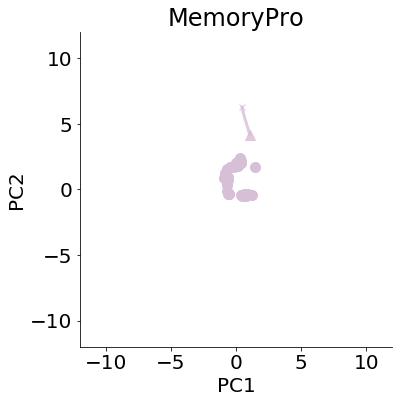

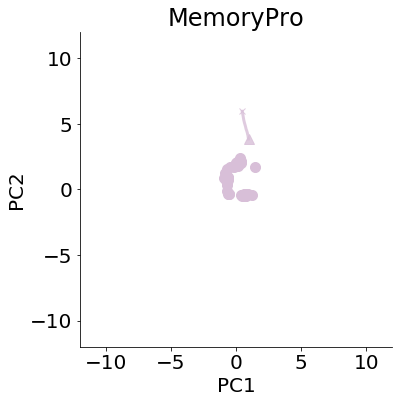

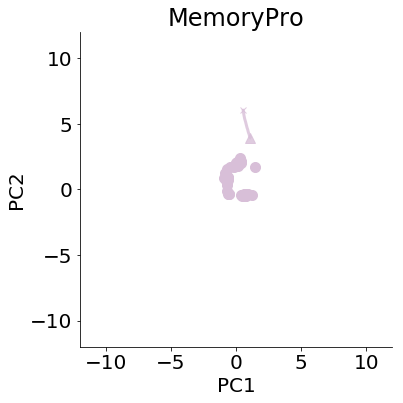

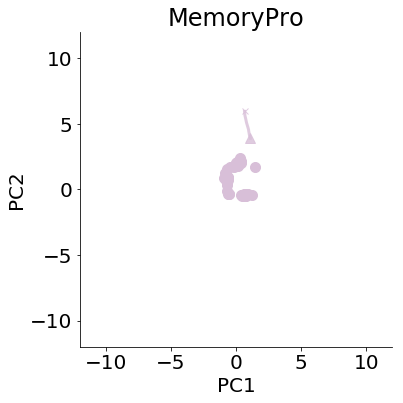

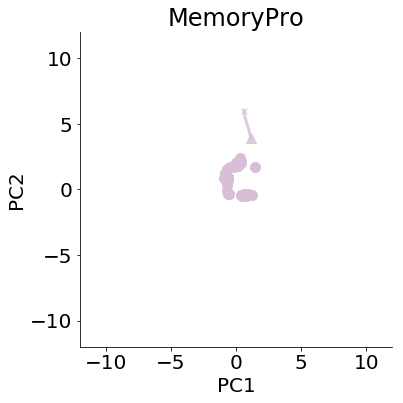

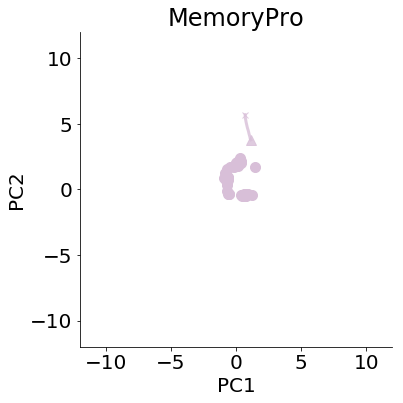

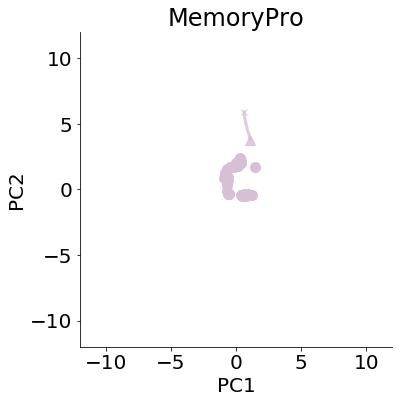

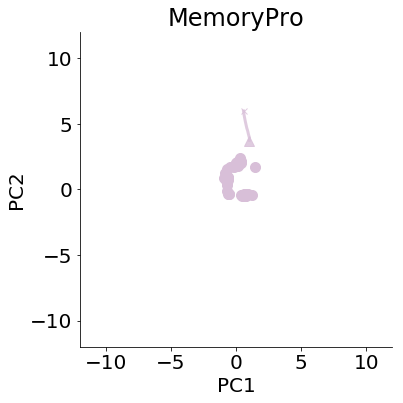

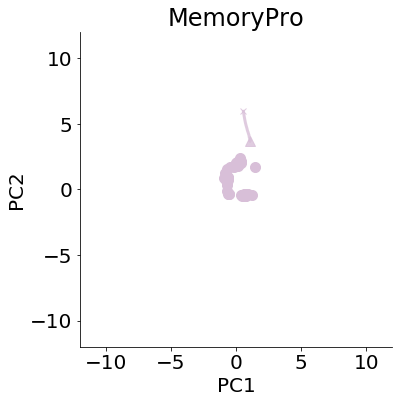

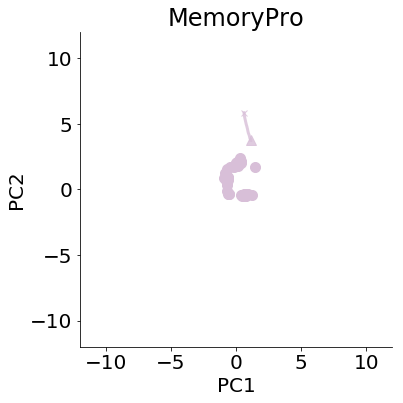

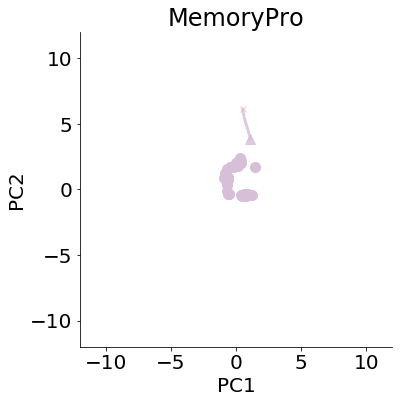

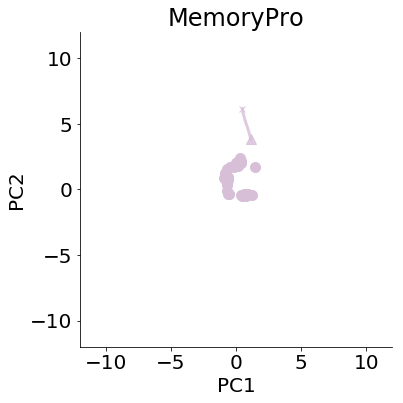

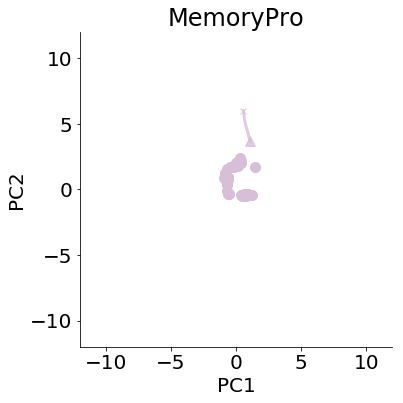

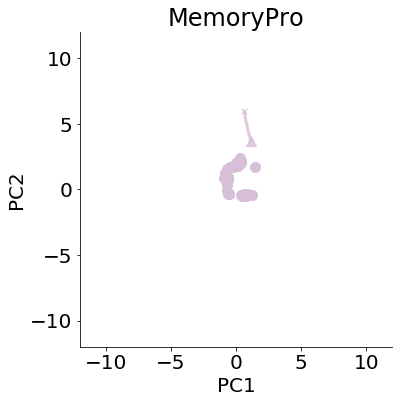

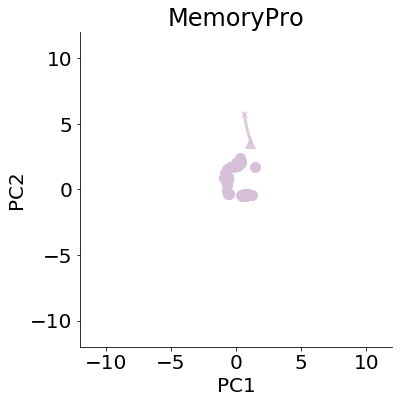

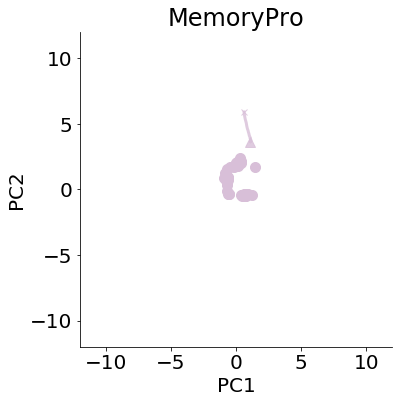

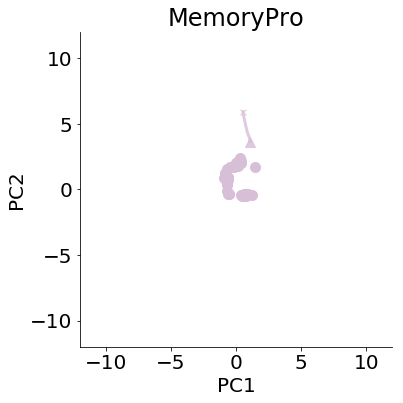

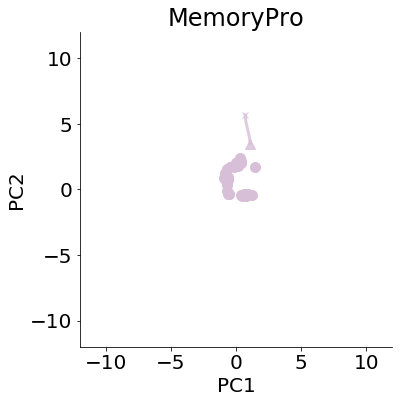

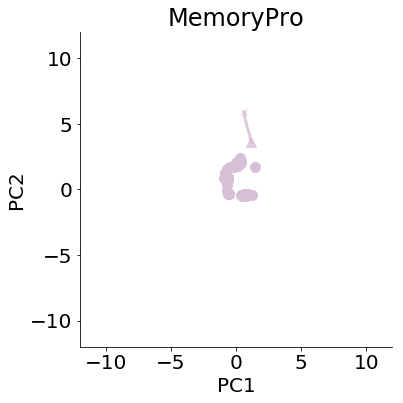

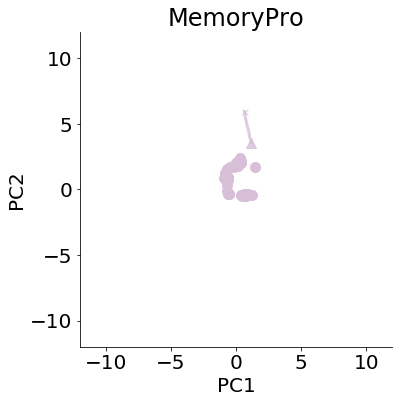

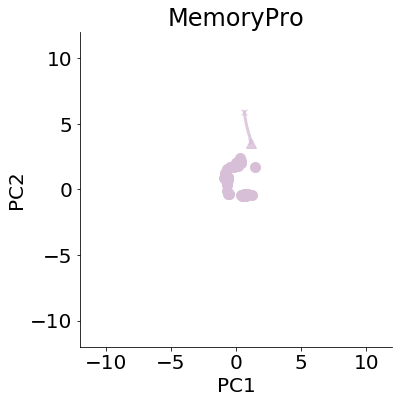

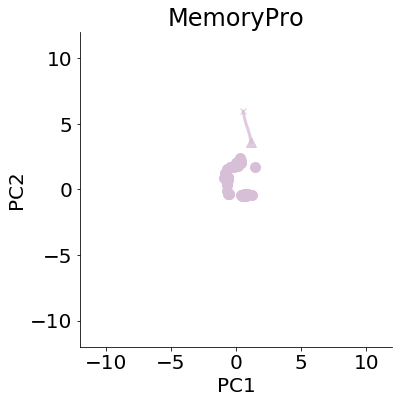

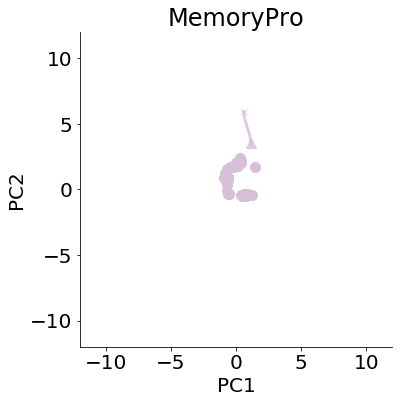

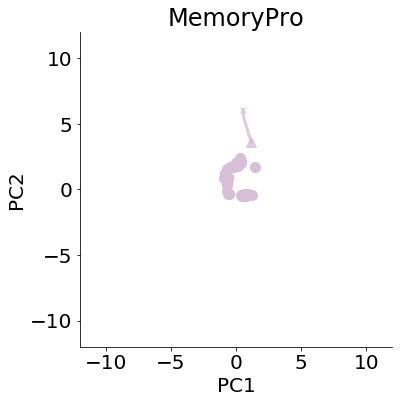

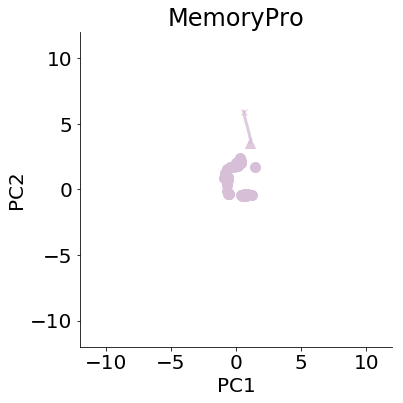

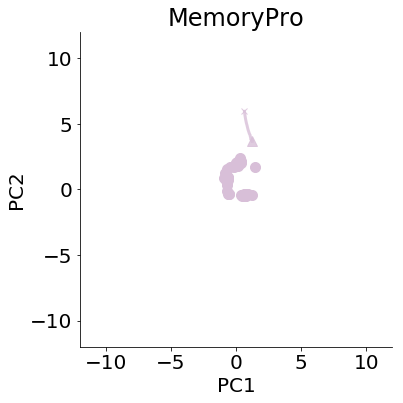

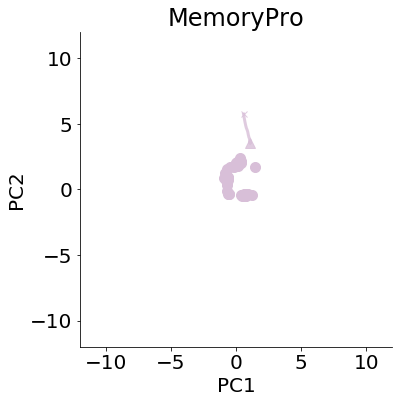

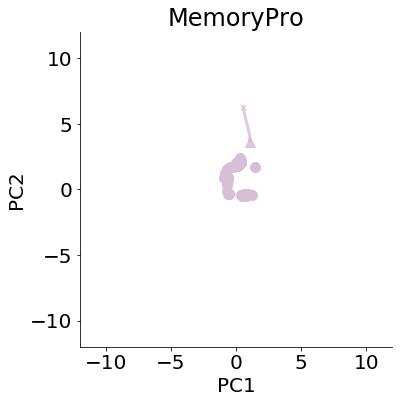

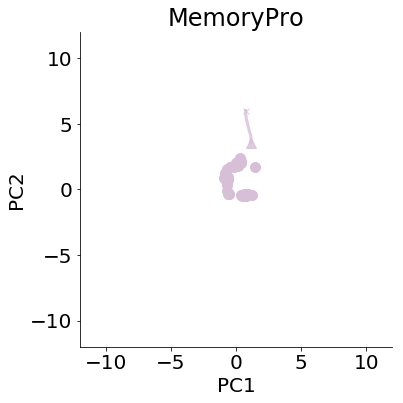

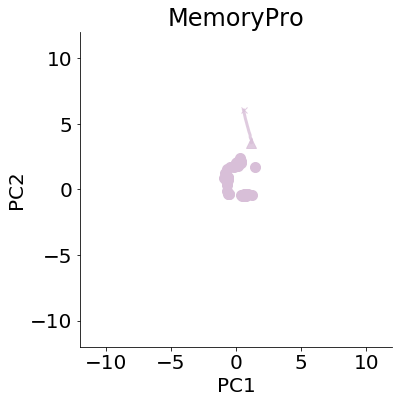

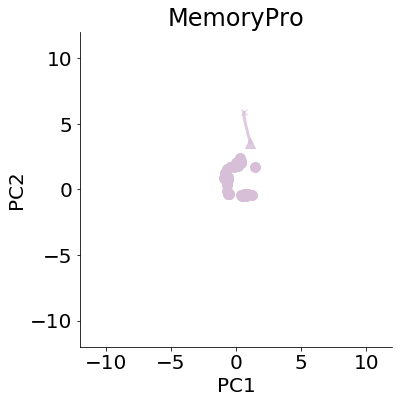

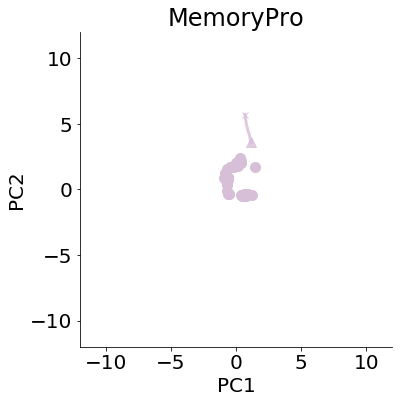

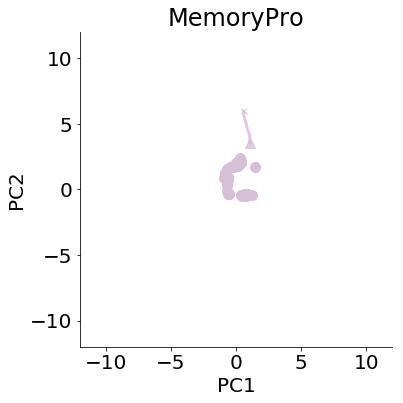

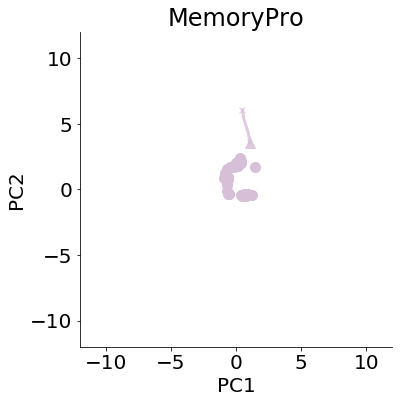

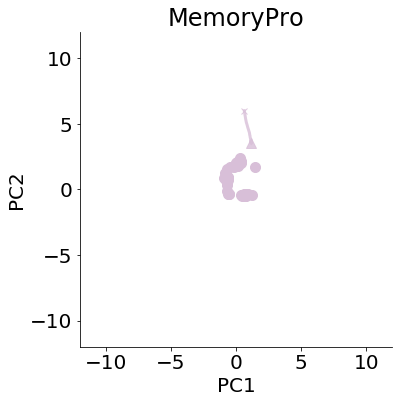

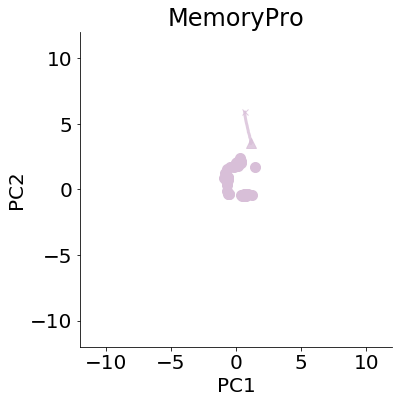

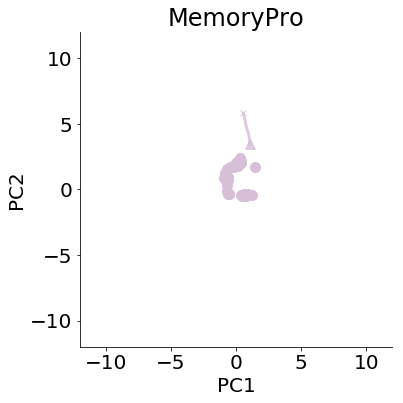

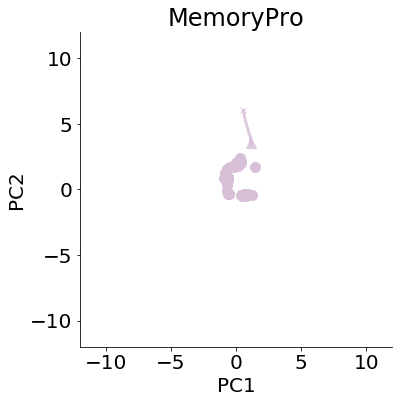

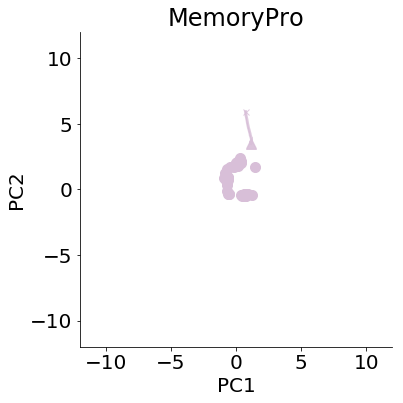

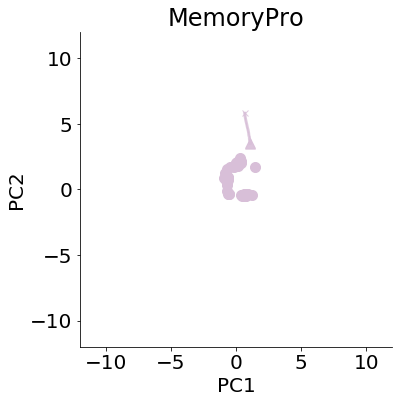

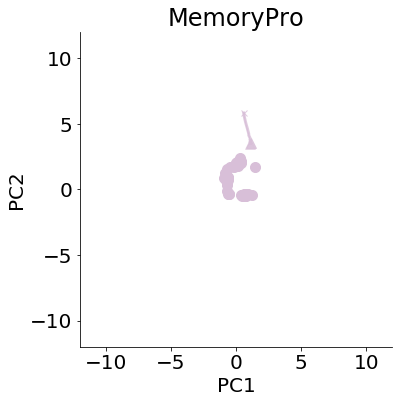

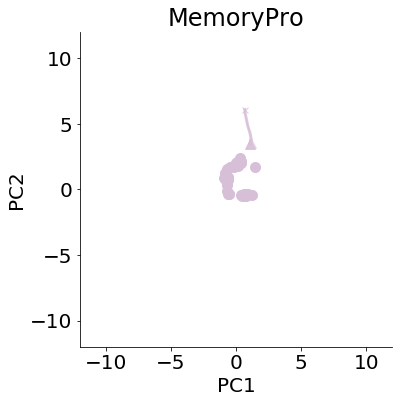

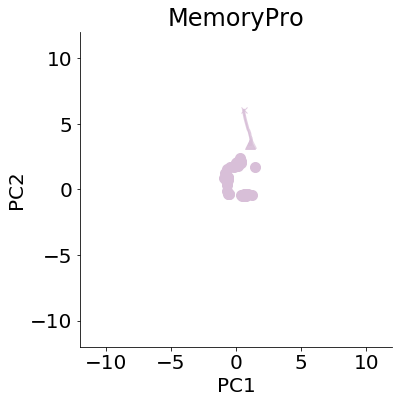

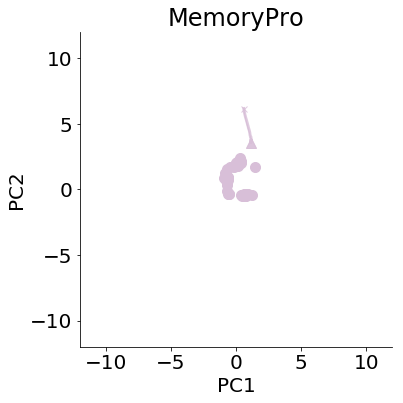

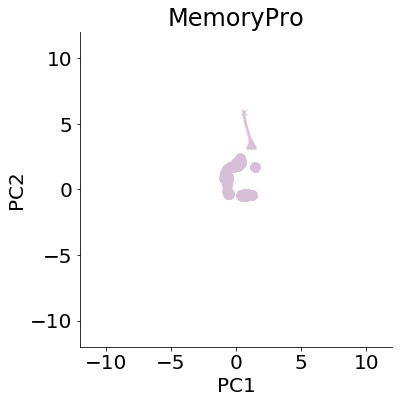

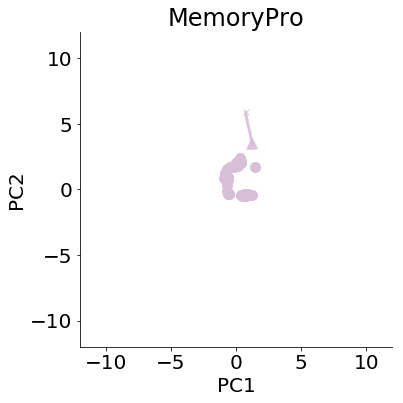

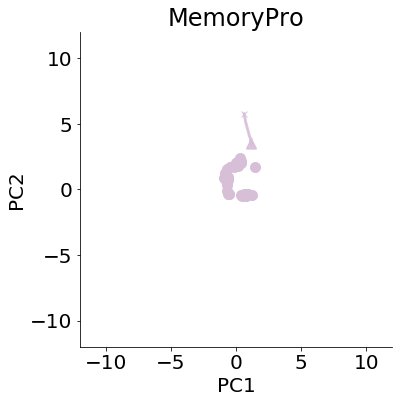

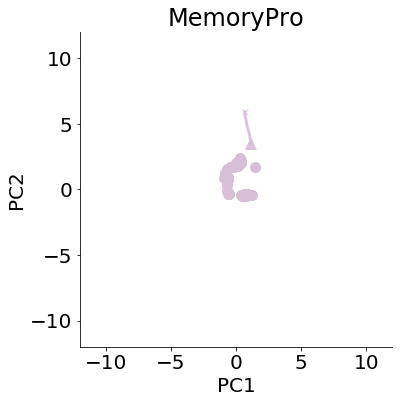

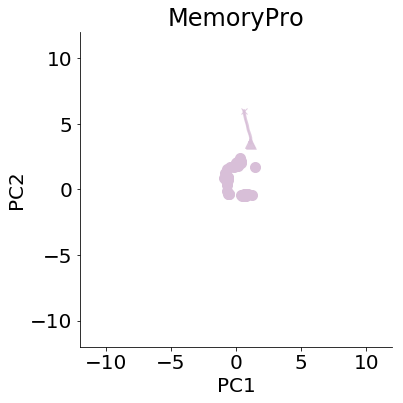

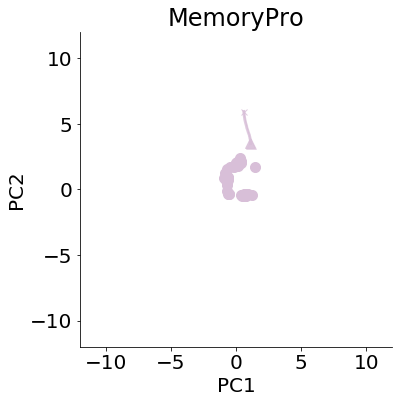

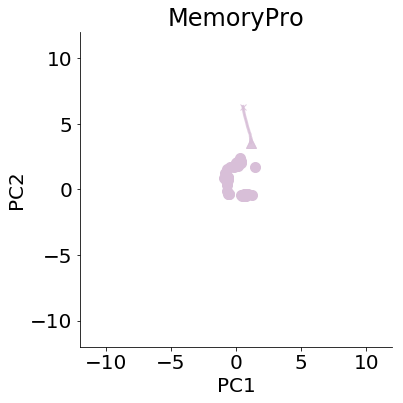

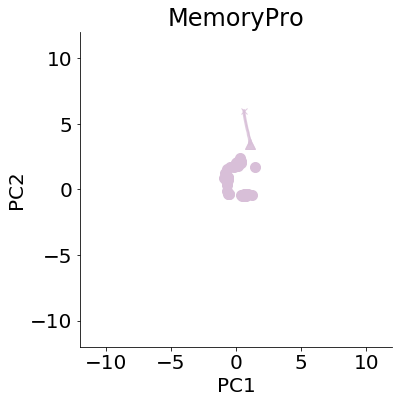

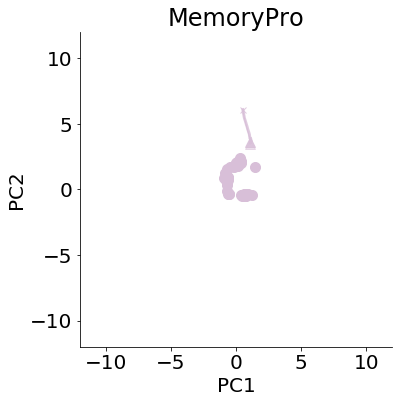

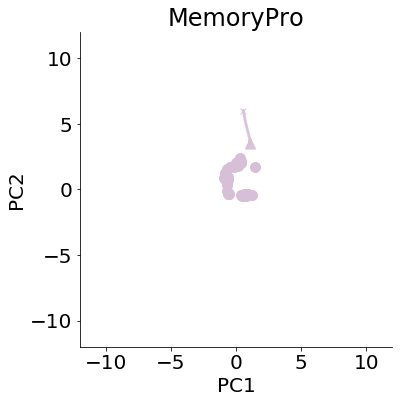

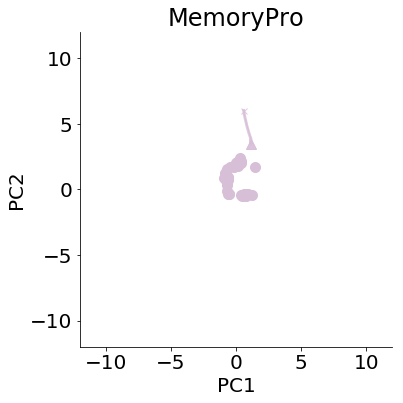

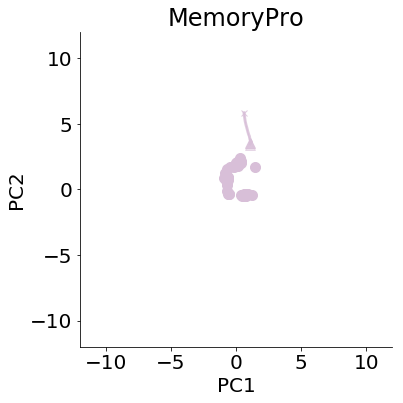

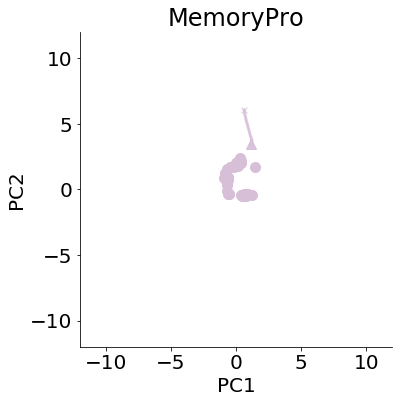

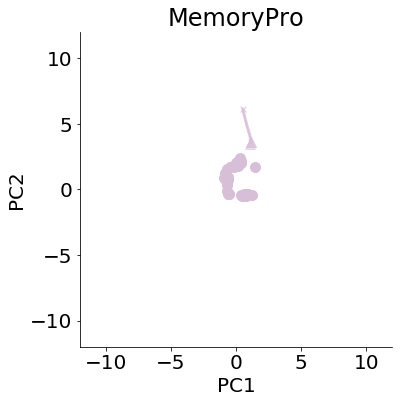

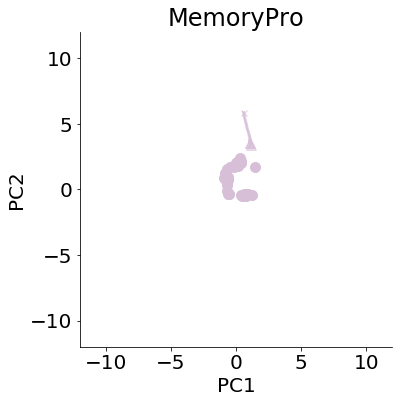

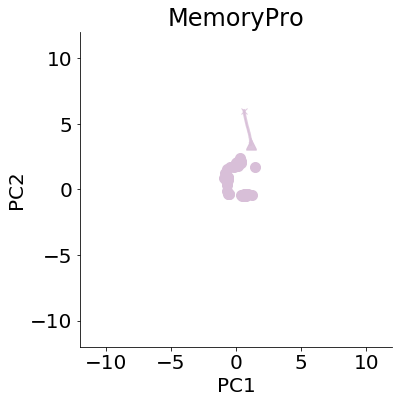

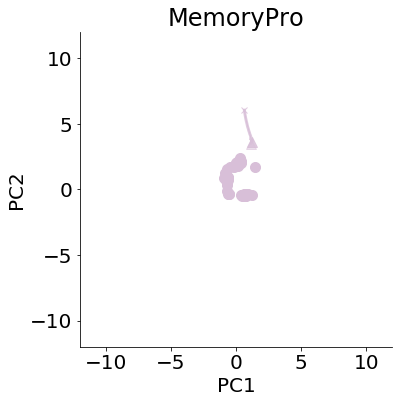

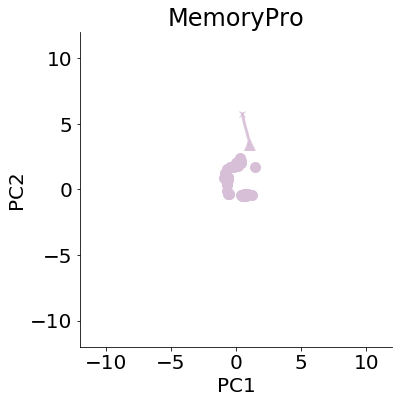

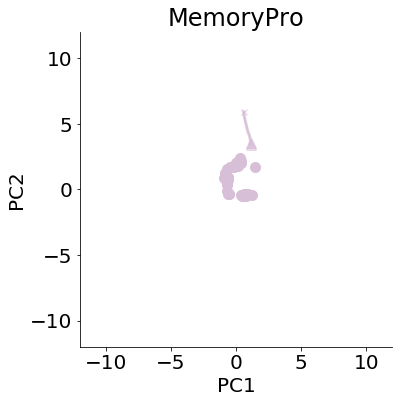

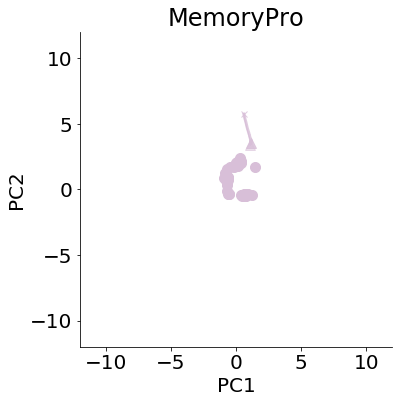

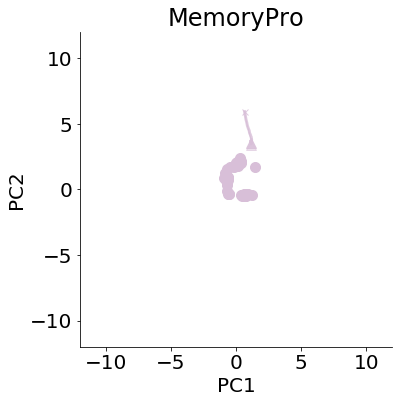

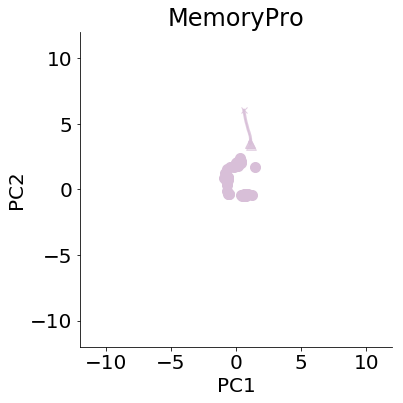

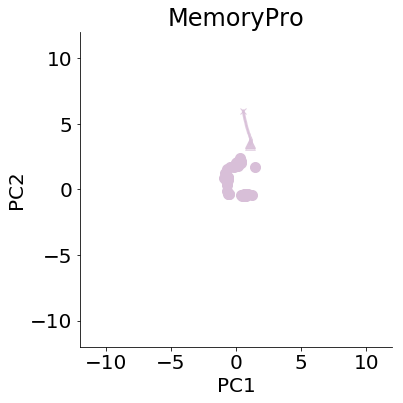

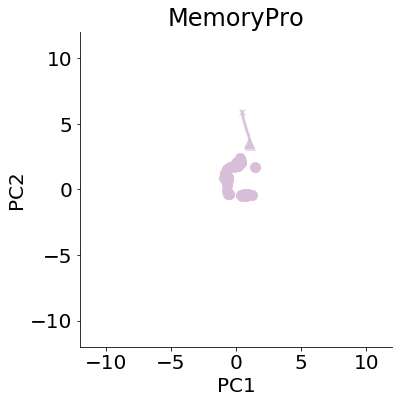

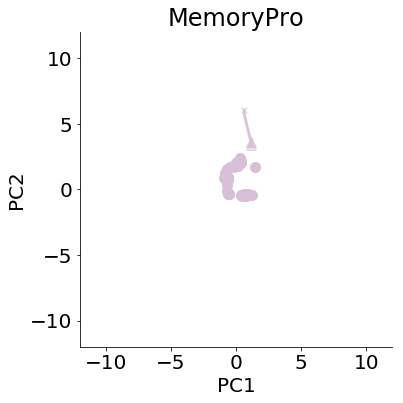

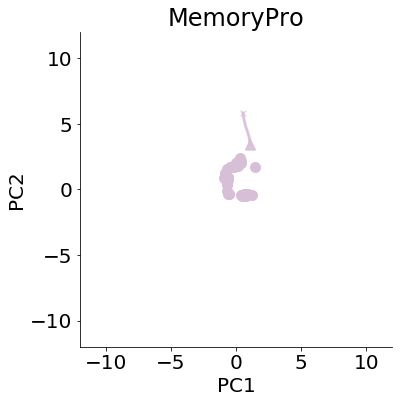

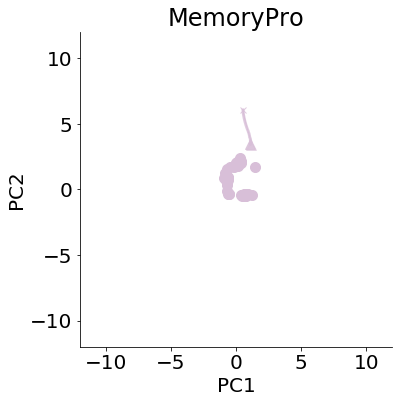

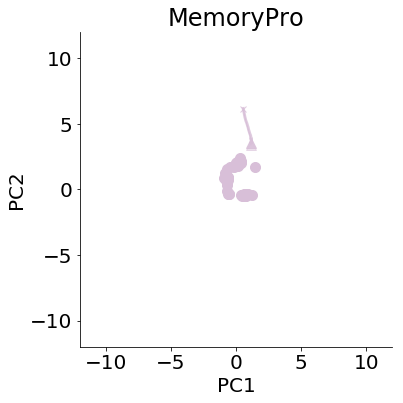

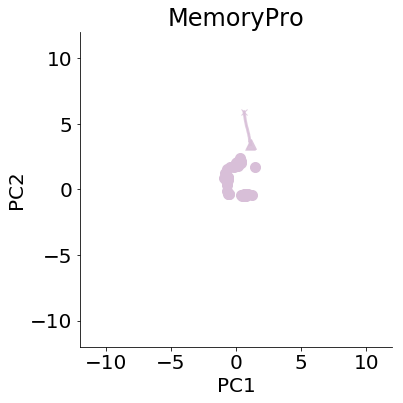

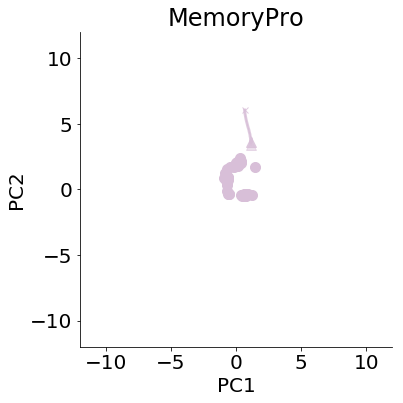

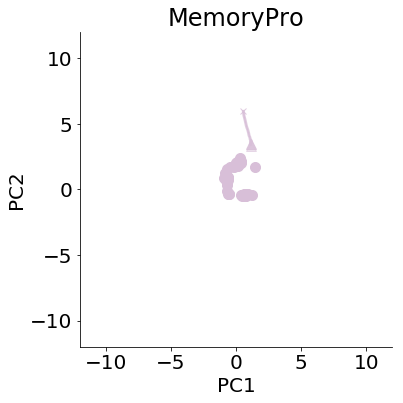

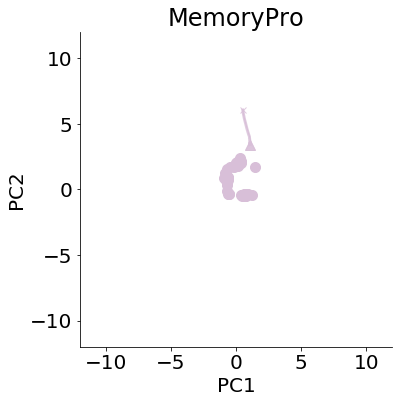

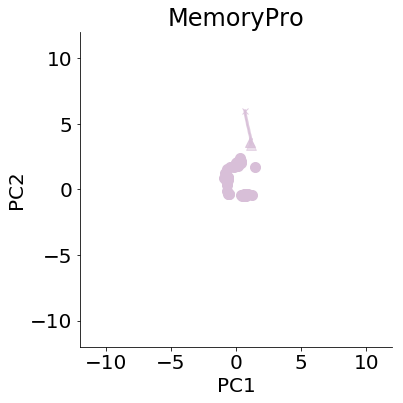

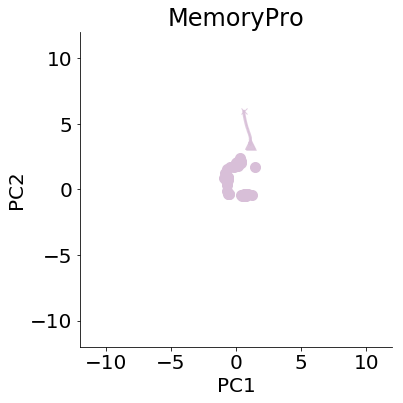

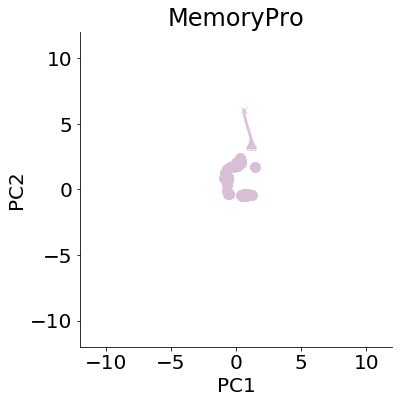

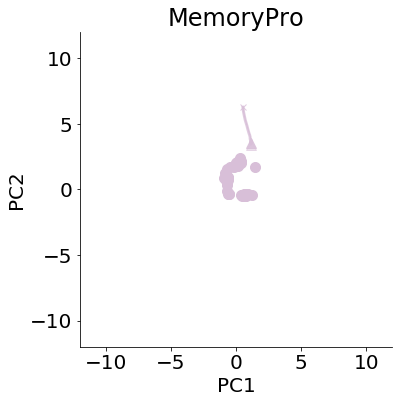

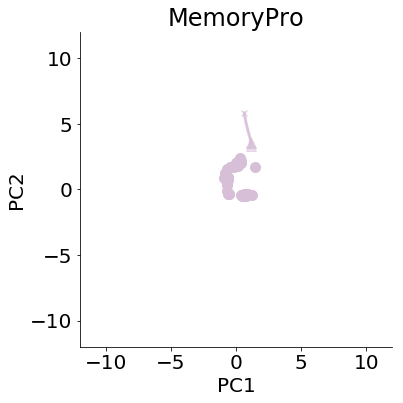

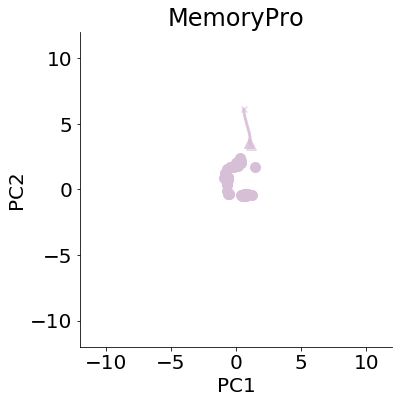

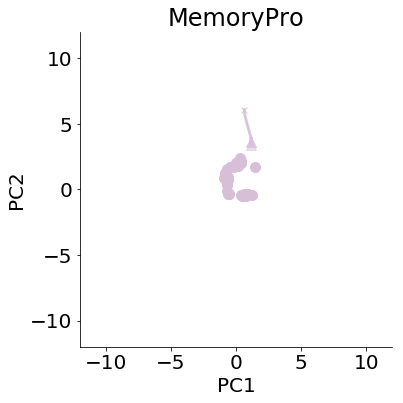

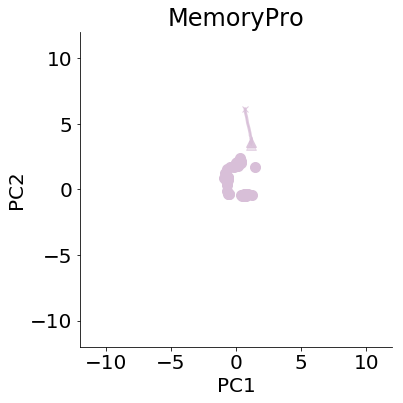

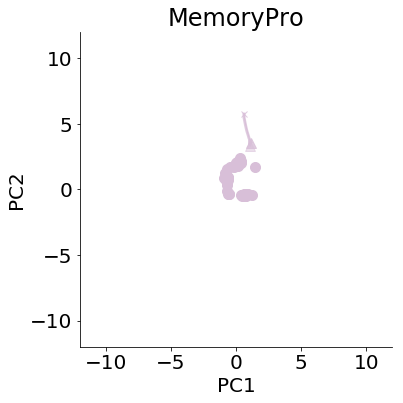

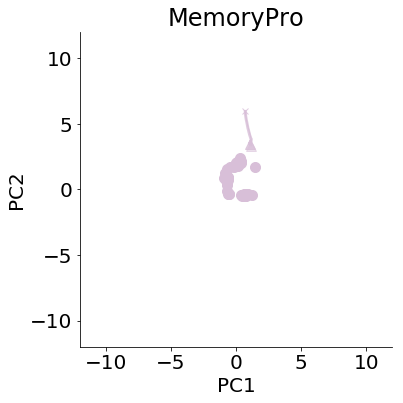

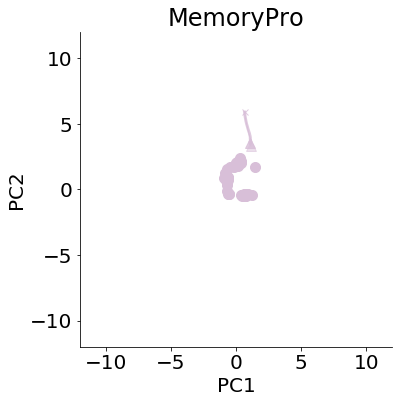

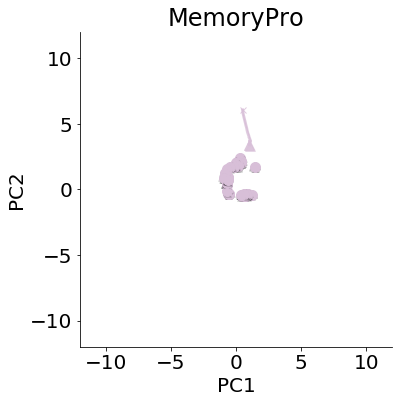

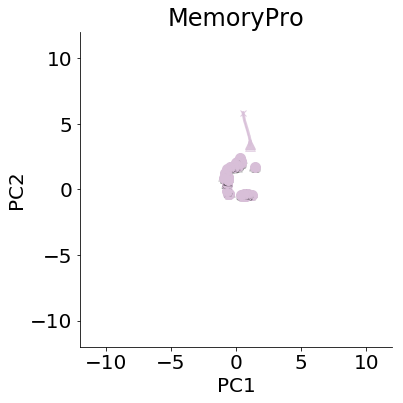

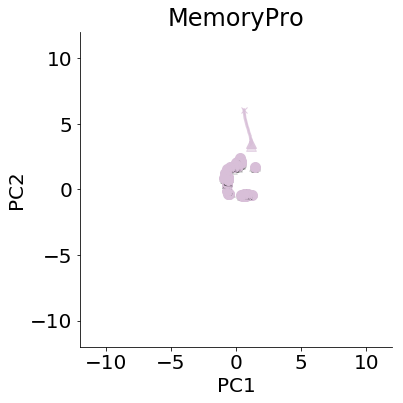

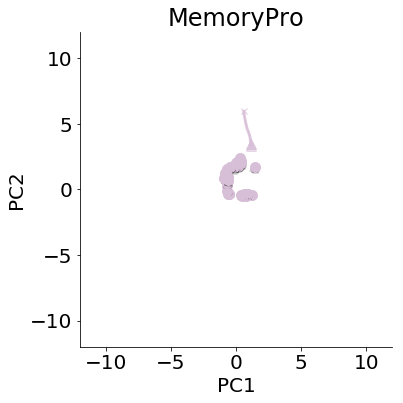

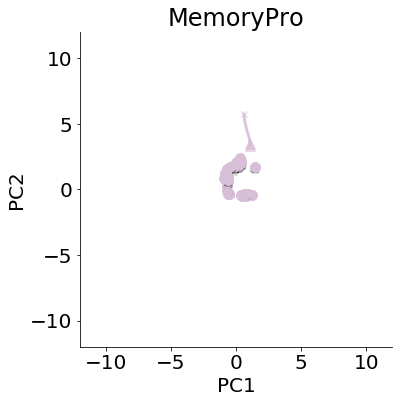

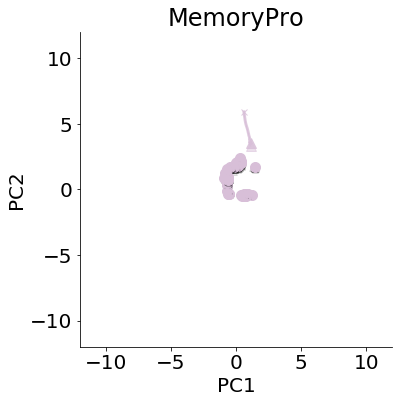

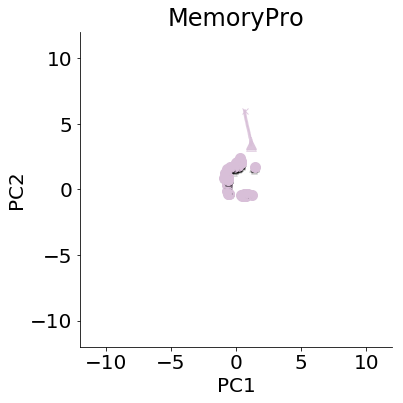

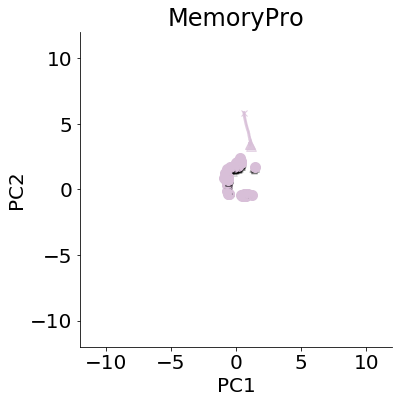

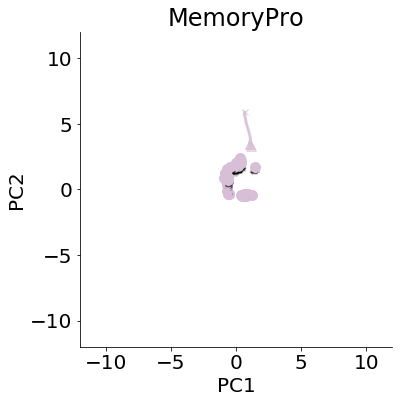

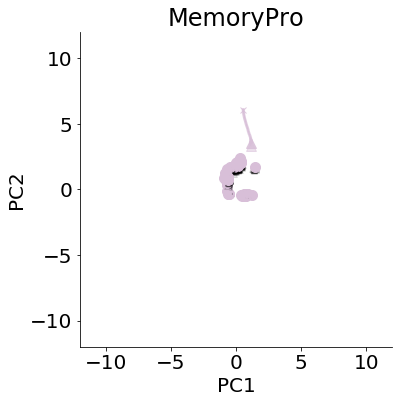

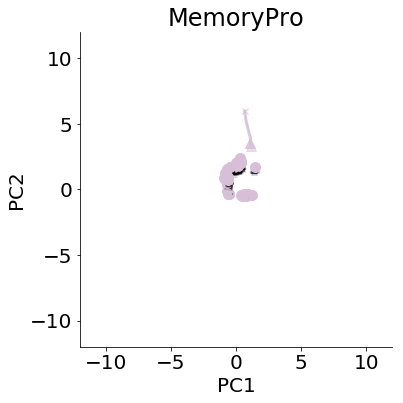

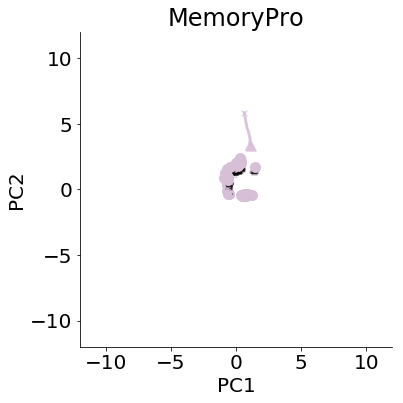

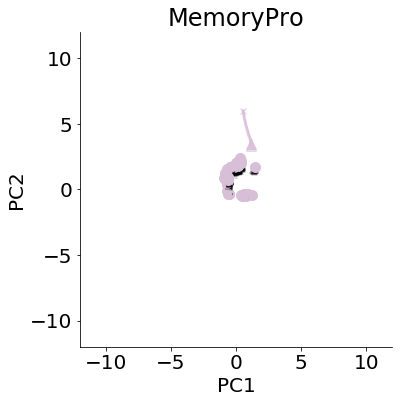

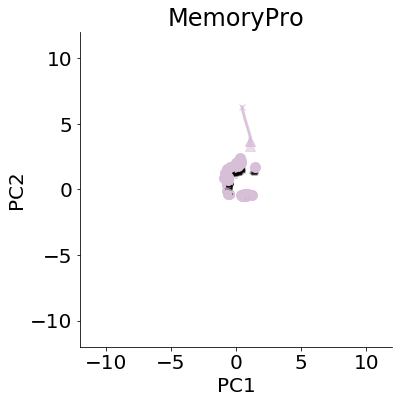

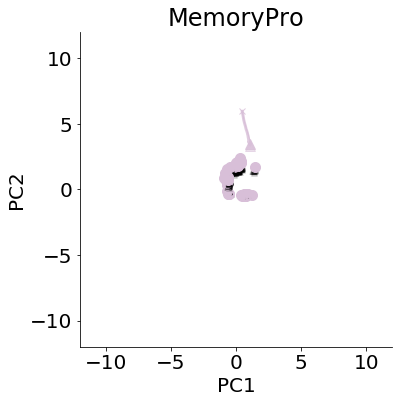

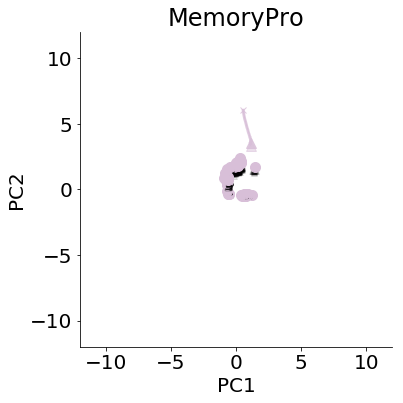

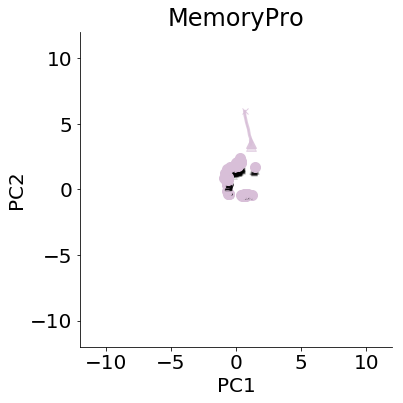

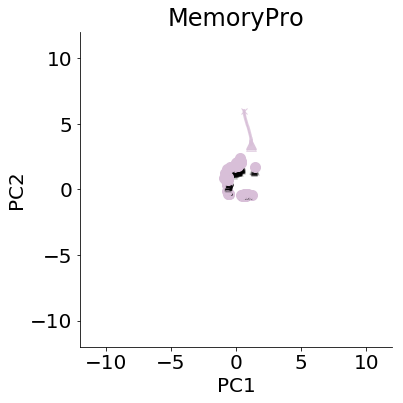

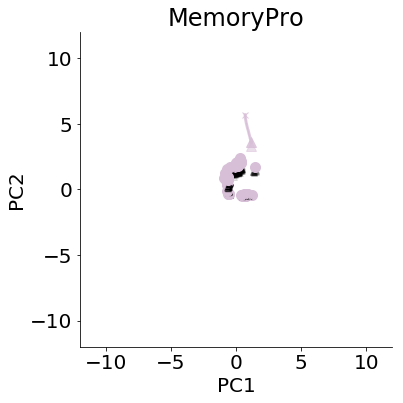

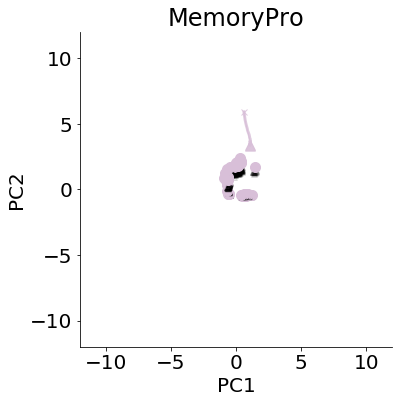

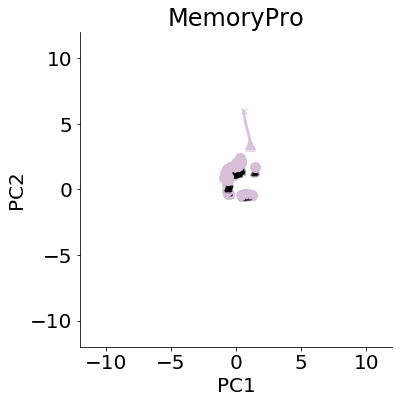

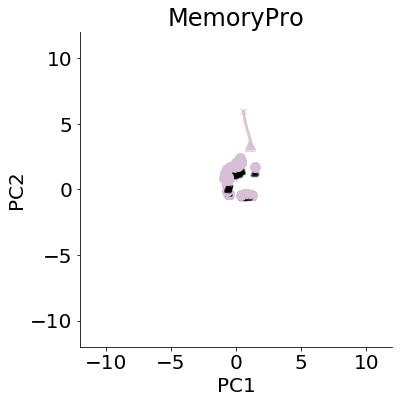

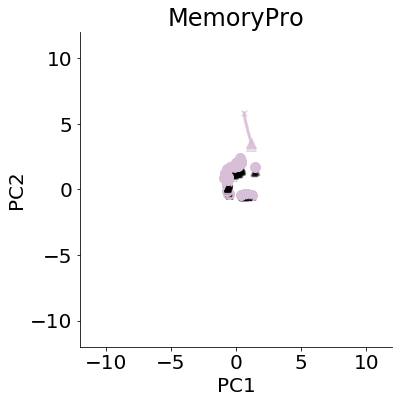

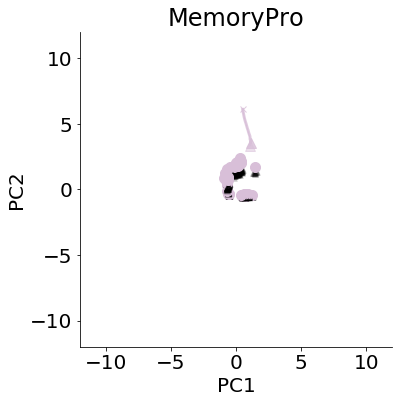

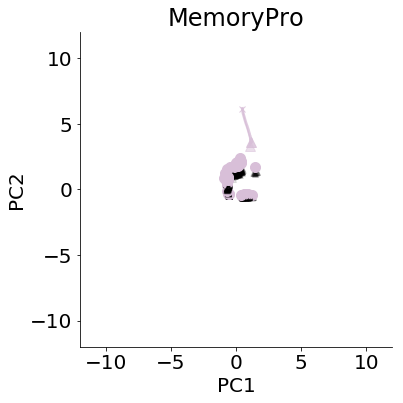

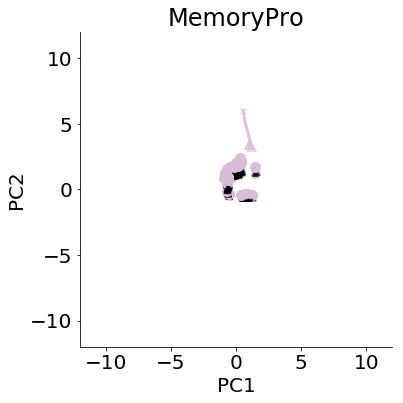

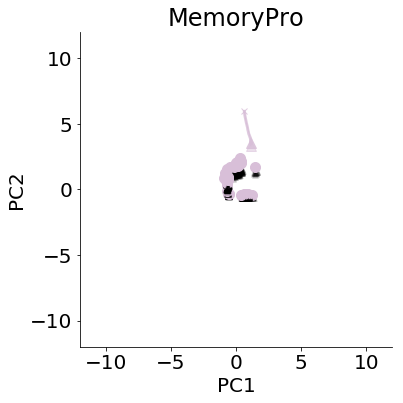

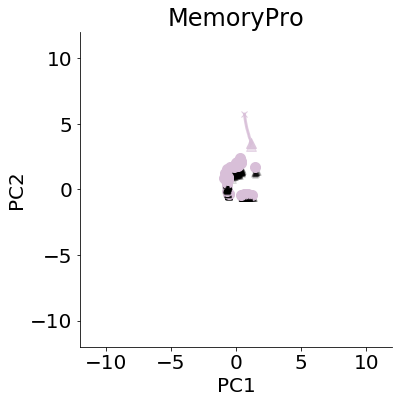

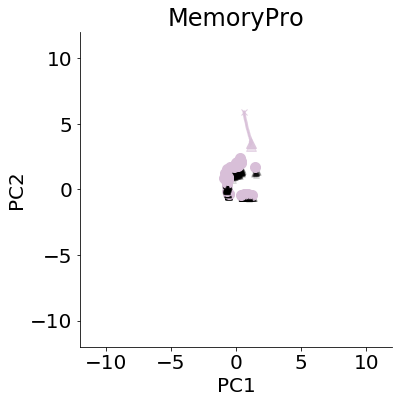

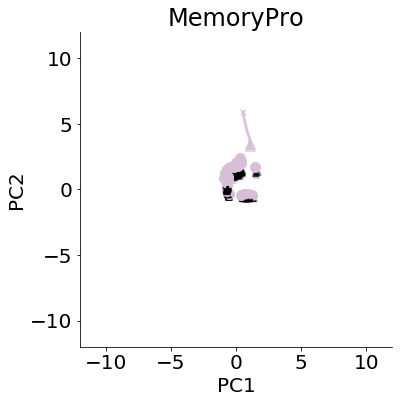

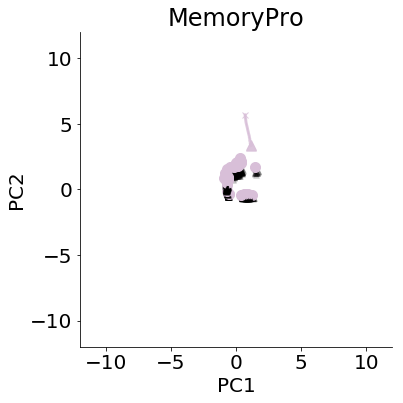

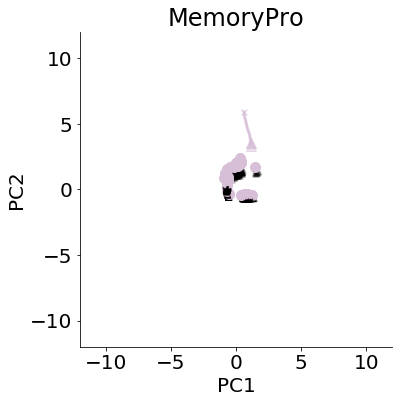

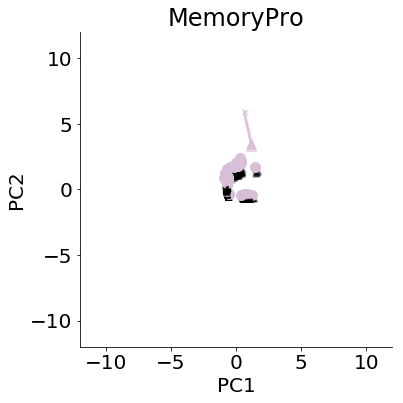

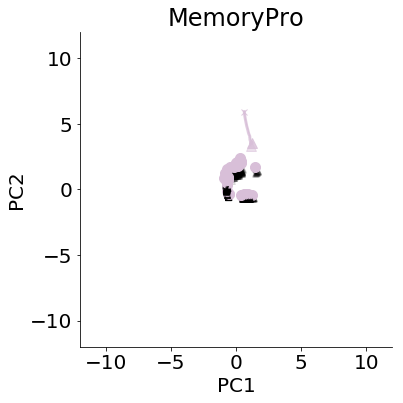

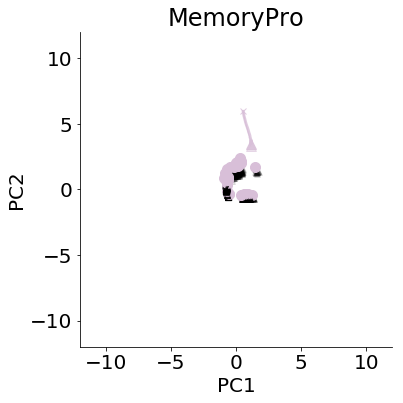

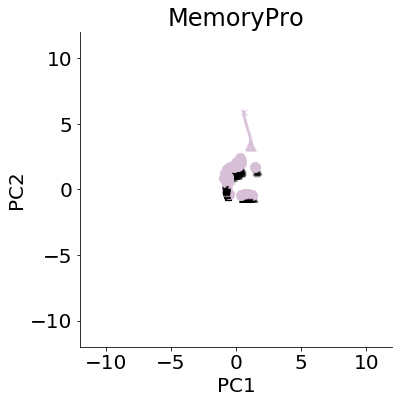

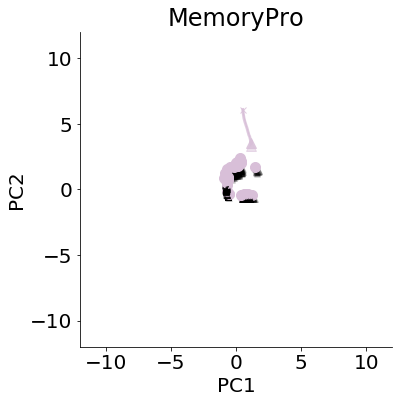

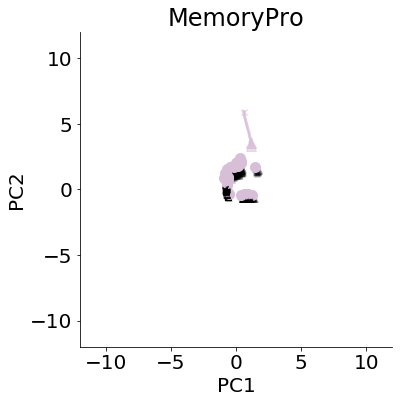

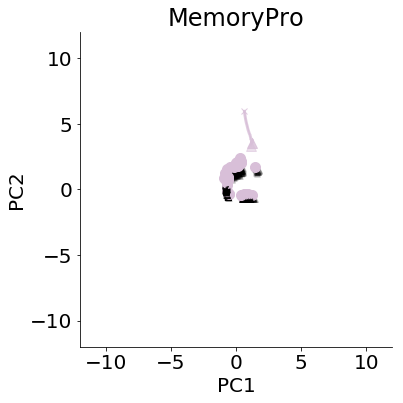

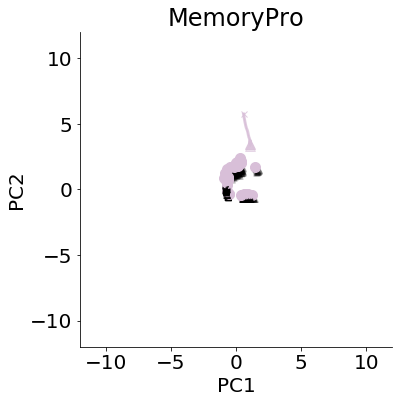

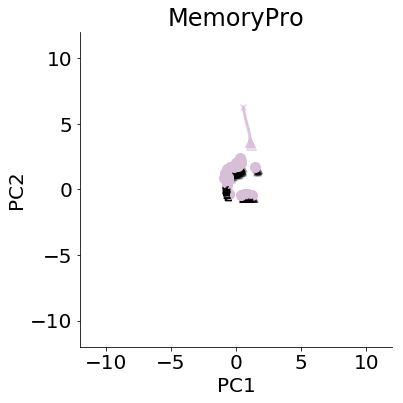

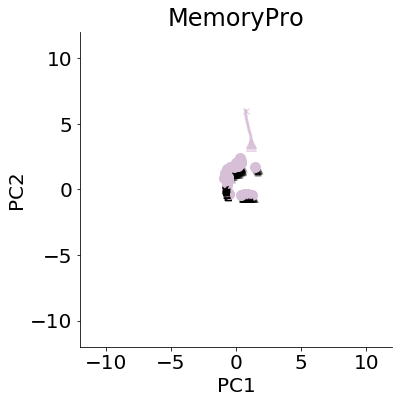

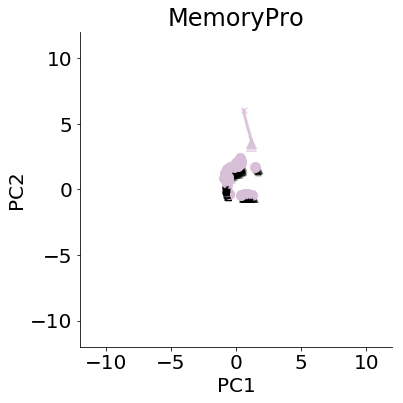

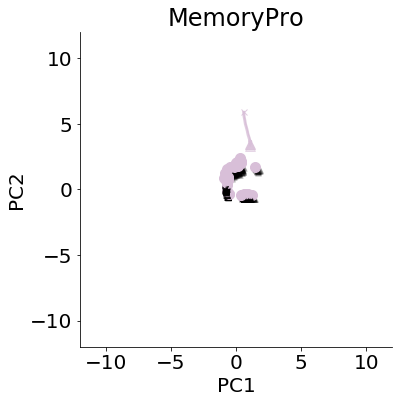

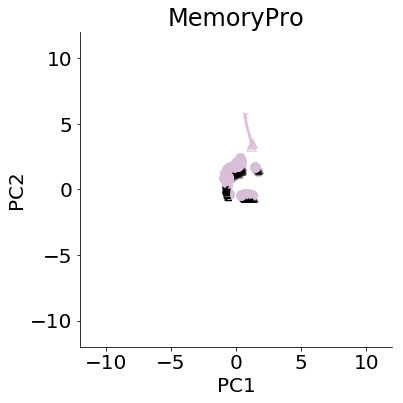

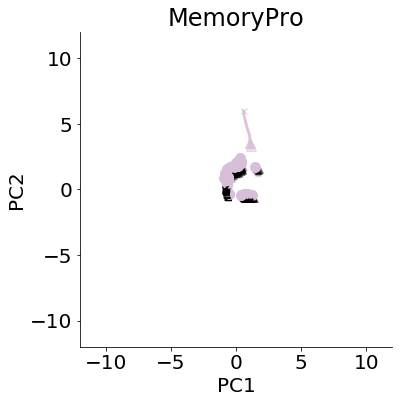

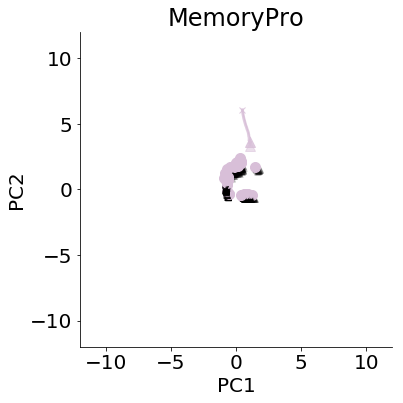

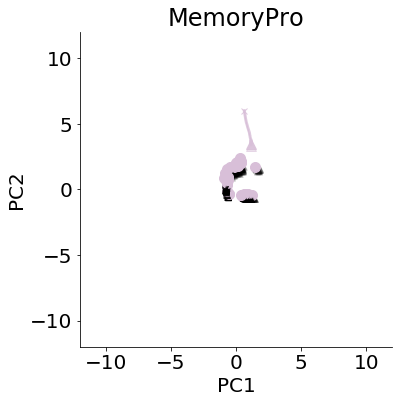

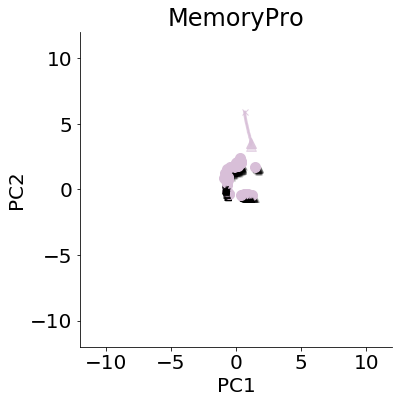

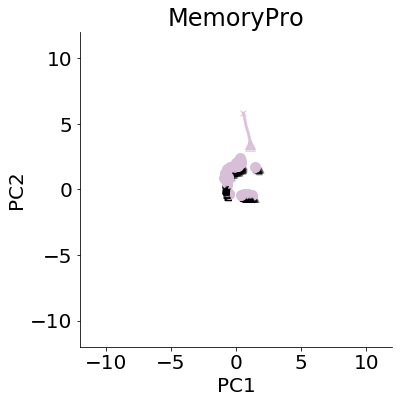

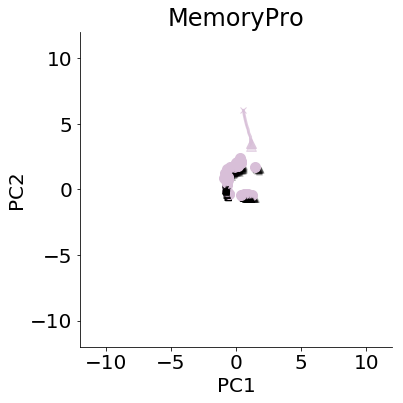

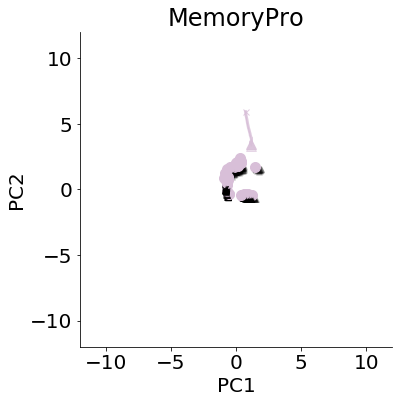

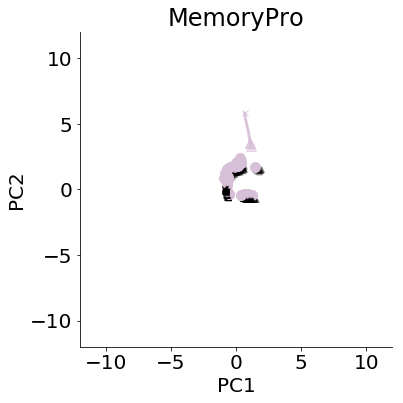

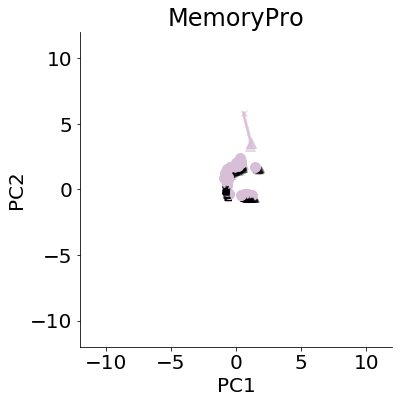

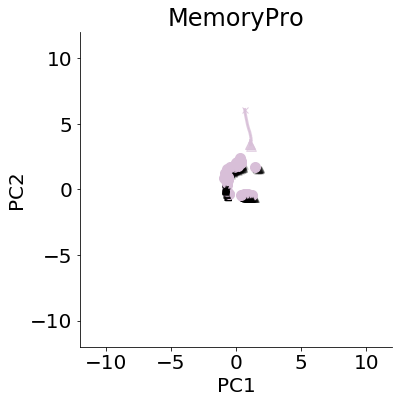

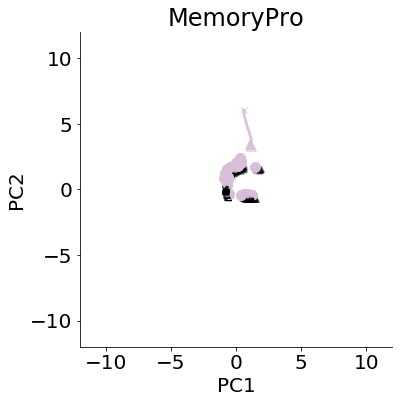

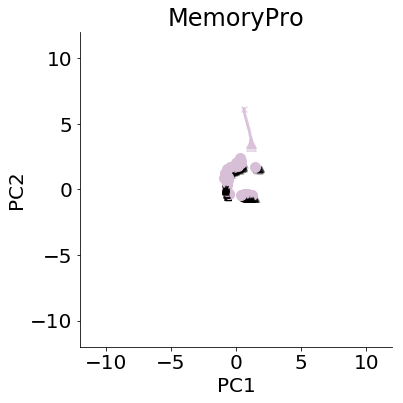

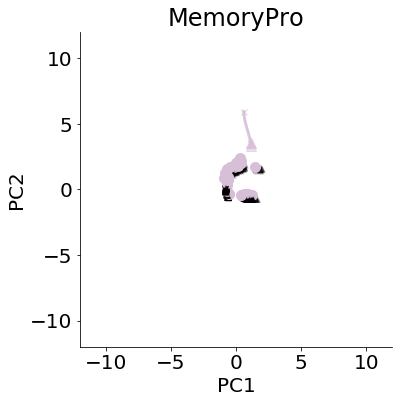

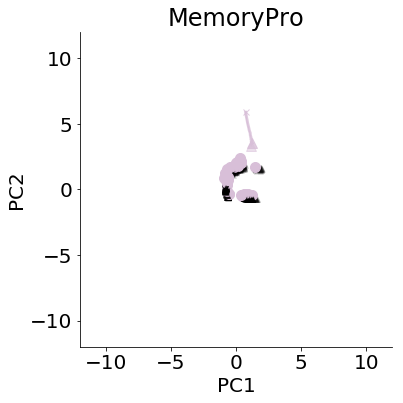

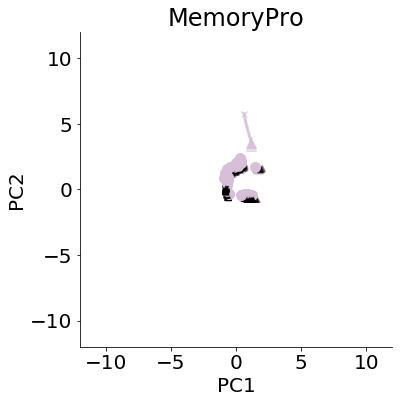

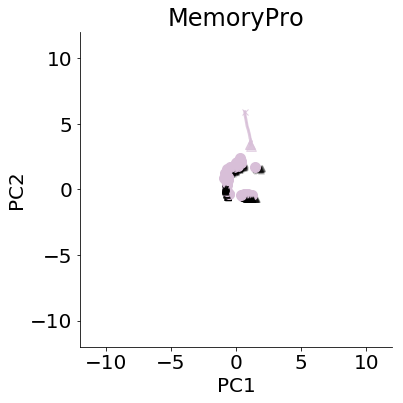

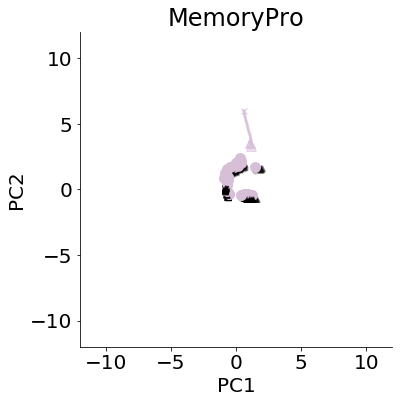

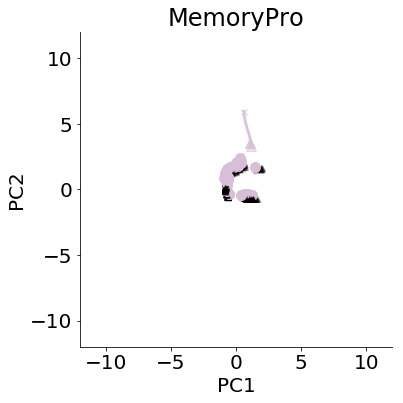

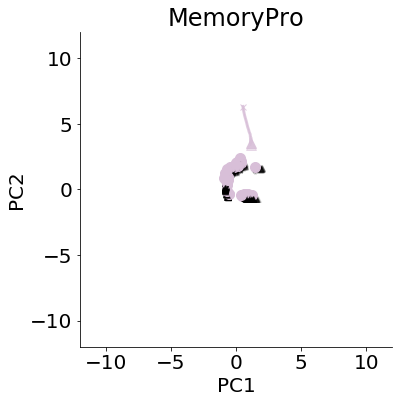

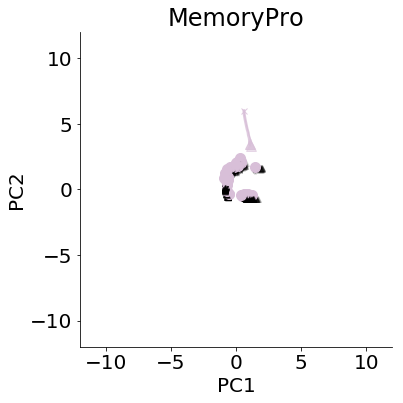

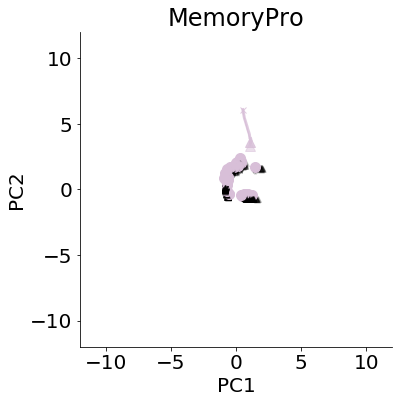

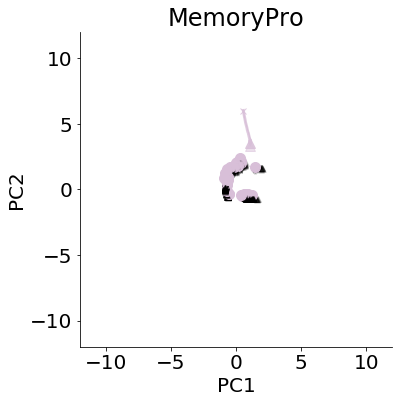

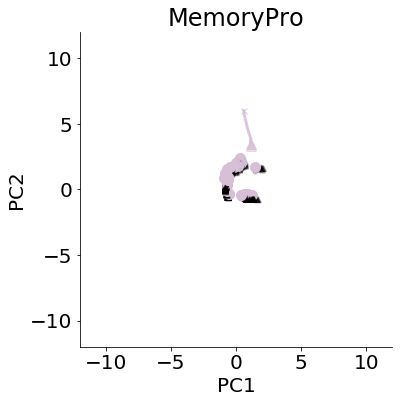

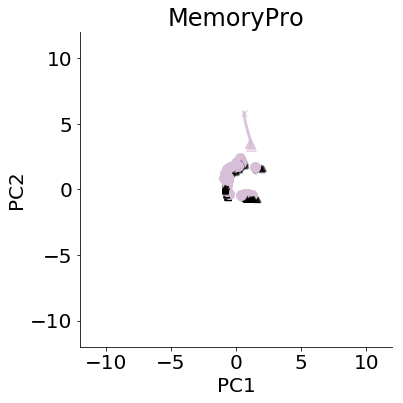

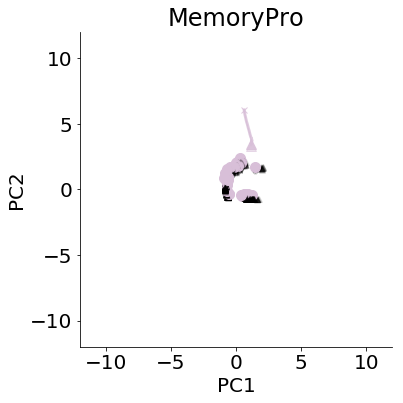

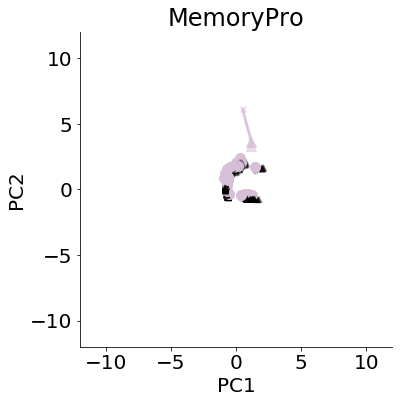

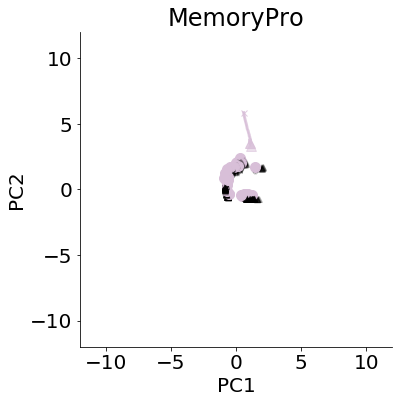

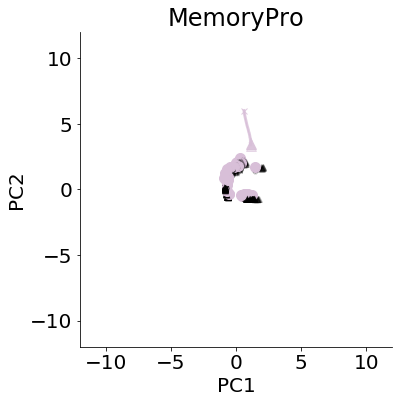

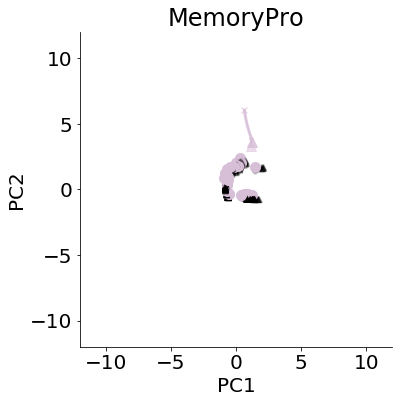

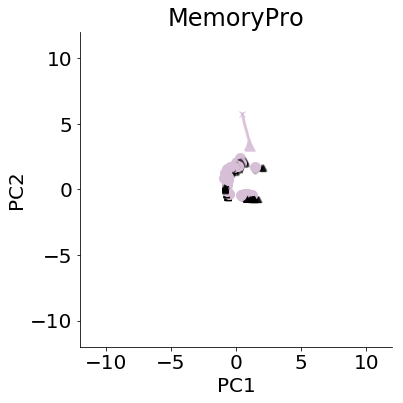

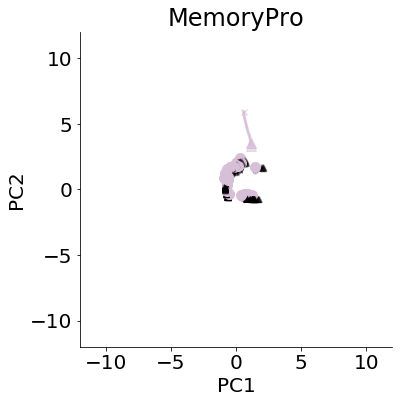

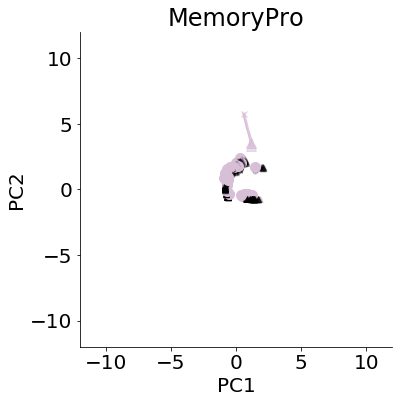

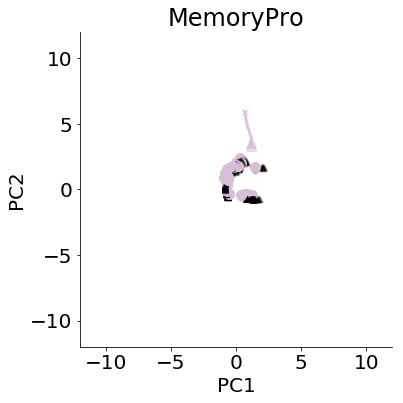

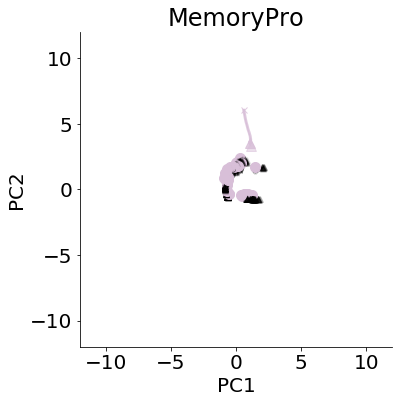

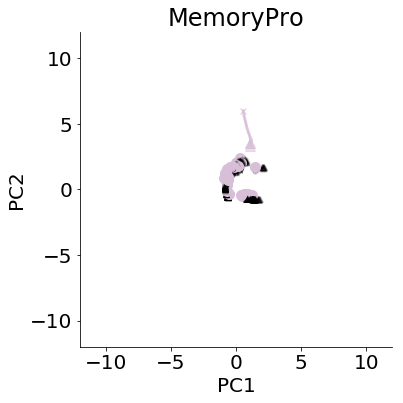

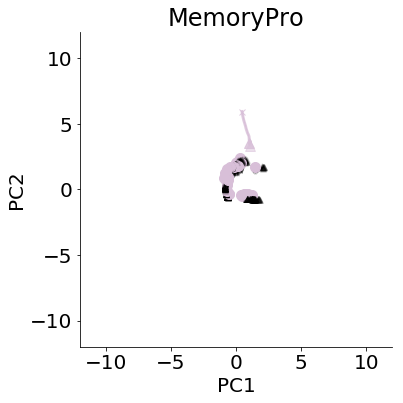

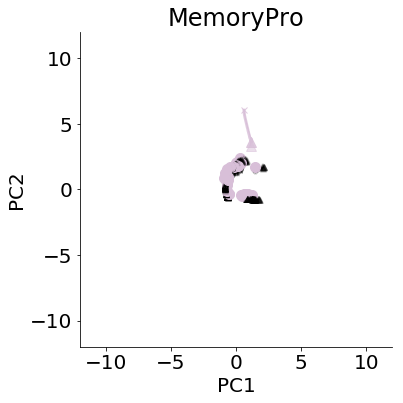

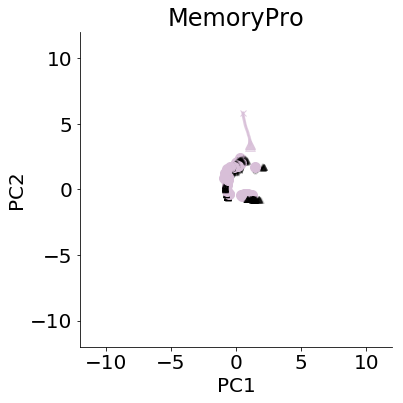

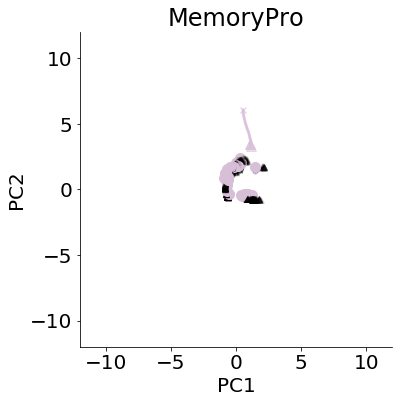

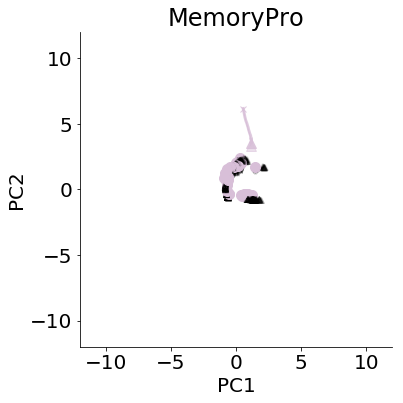

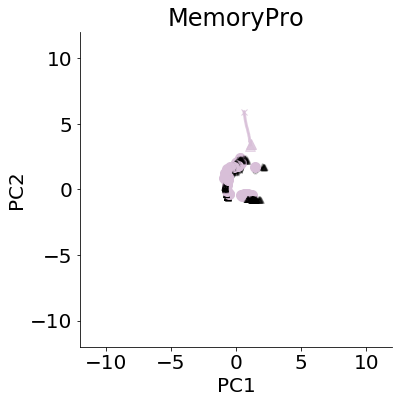

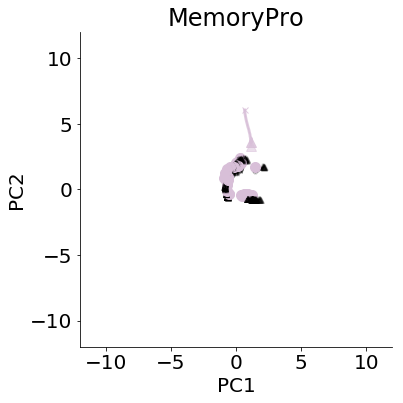

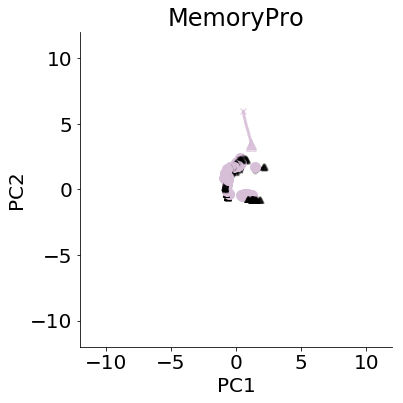

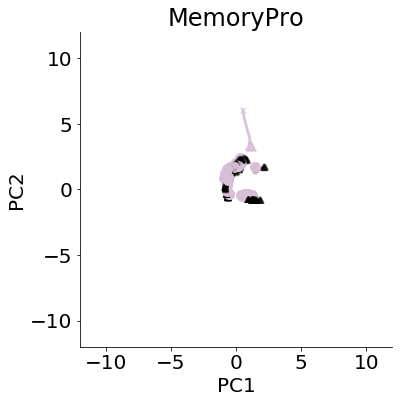

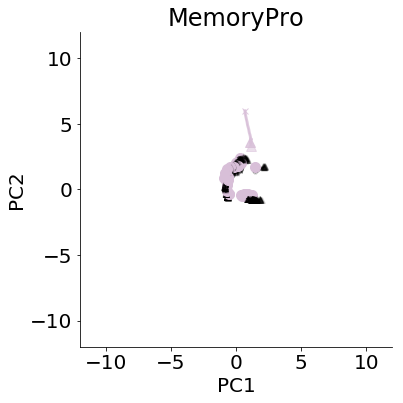

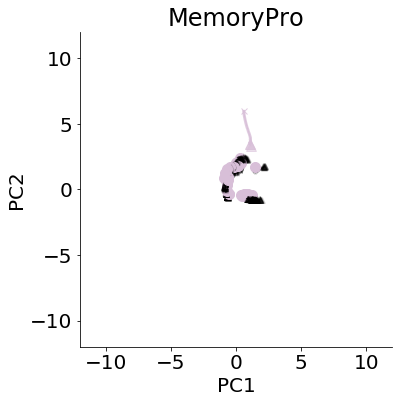

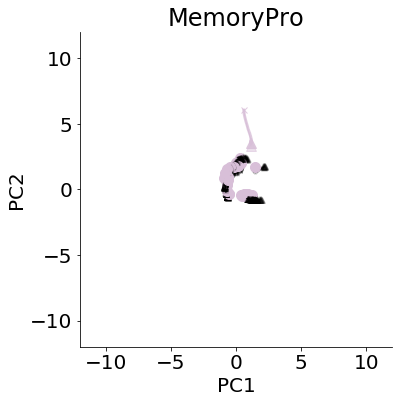

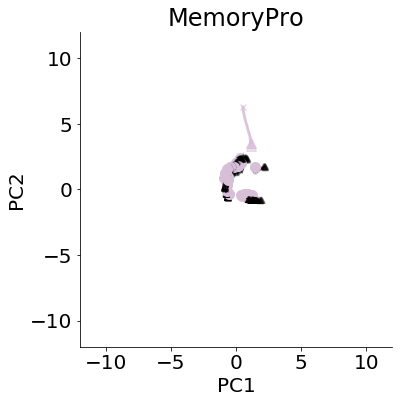

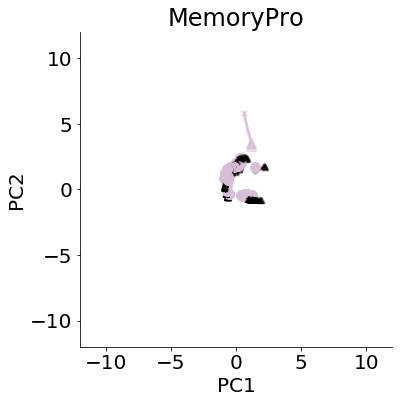

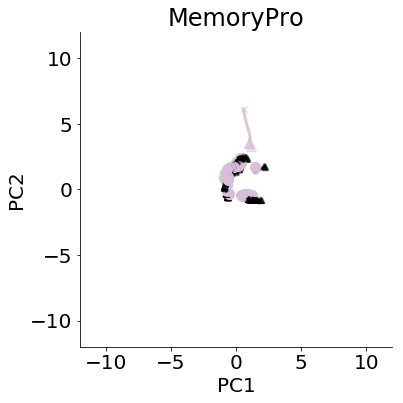

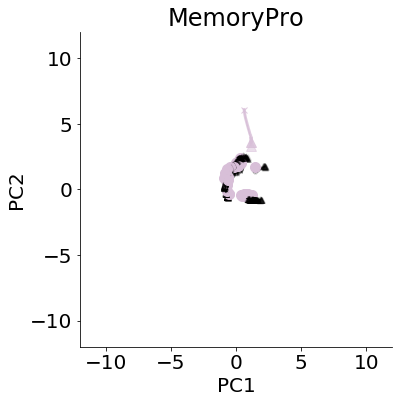

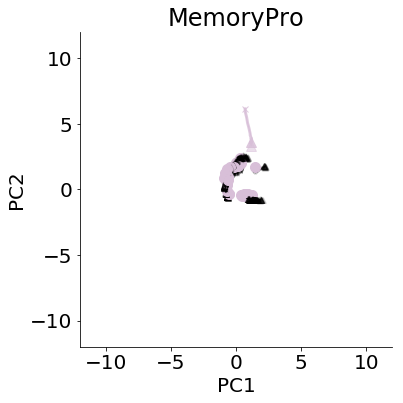

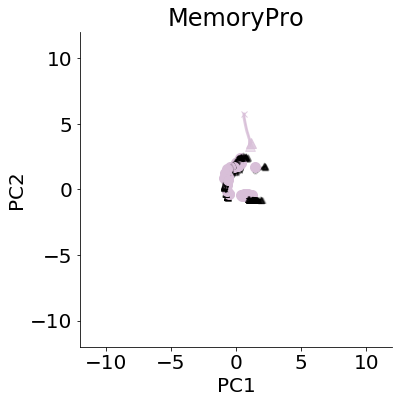

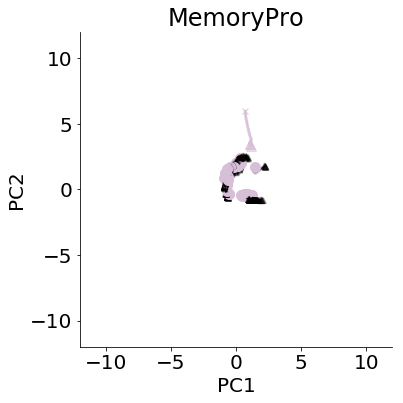

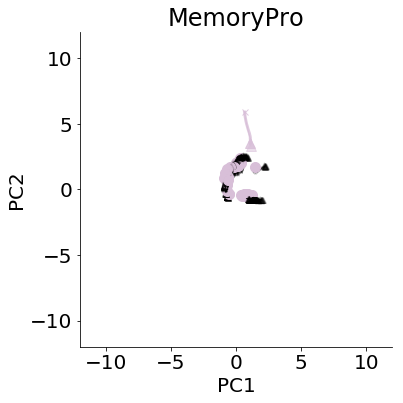

In [23]:
task_list = ['delaygo','dmsgo']
color_set = ['thistle','brown']

offset = 0
fp_t_num = [0+offset, 180+offset]
t_num = int(fp_t_num[0]/4)

eig_decomps, sorted_fps, fp_inds, f = load_fps(m_all,task_list[0],'delay1',t_num_deg = fp_t_num[0])
D_use, _, _ = make_FP_axs(f,m_all,task_list[0],'stim1',axs = 'pca_h')
    
for ri in [0,]:
    rule_in = task_list[ri]
    
    print(rule_in)
    
    c = color_set[ri]
    ind_stim_loc = fp_t_num[ri]
    
    for epoch in ['delay1',]:
        
        eig_decomps, sorted_fps, fp_inds, f = load_fps(m_all,rule_in,epoch,t_num_deg = ind_stim_loc)
        
        fp_mov(m_all,D_use,rule_in,t_num,epoch,sorted_fps,fp_inds,eig_decomps,[rule_in,],
           xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
           lw = 3,al = .6,linestyle = '-',n_jit = 0,c_master = c,plot_other_trials = False)
        
        jitter_mov(m_all,D_use,rule_in,t_num,epoch,sorted_fps,fp_inds,eig_decomps,[rule_in,],
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 20,c_master = c,plot_other_trials = False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/single_tasks/l2w0001/fdgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/single_tasks/l2w0001/fdgo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/laura

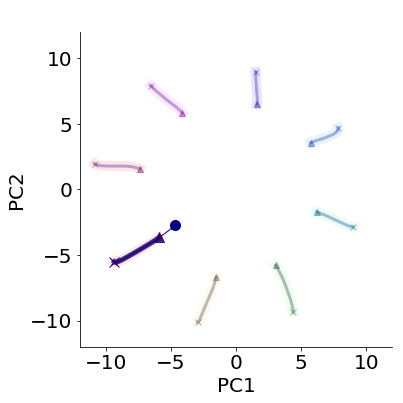

In [25]:
fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
color_list = ['navy','gold']
fp_t_num = [0, 180]
t_num = 0
opp = [1,0]
rand_step_coef = 0.1
al = .3
axs = 'pca'
epoch = 'go1'
f = os.path.join(m_all,'tf_fixed_pts_all_init',task_list[0],epoch+'_'+str(fp_t_num[ri])+'.0.npz')
D_use, _, _ = make_FP_axs(f,m_all,task_list[0],'stim1',axs = 'pca_h')
trial_set = range(0,80,10)
task_str = '_'.join(t for t in task_list)


for ri in range(len(task_list)):
    ax1 = plt.subplot(1,1,1)
    
    rule_in = task_list[ri]
#     rule_ic = task_list[opp[ri]]
    epoch_name, rule_in_name, _, _ = take_names(epoch,rule_in)
#     epoch_name, rule_ic_name, _, _ = take_names(epoch,rule_ic)

    trial = gen_trials_from_model_dir(m_all,rule_in,noise_on = False)

    if ri%2==0:
        linestyle = '-'
        linestyle_opp = ':'
    else:
        linestyle = ':'
        linestyle_opp = '-'
    
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,epoch+'_'+str(fp_t_num[ri])+'.0.npz')
    fp_struct = np.load(f)
    J_xstar = fp_struct['J_xstar']
    eig_decomps = comp_eig_decomp(J_xstar)
    sorted_fps = fp_struct['xstar']
    fp_inds = range(len(sorted_fps))
    qvals = fp_struct['qstar']
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,epoch,sorted_fps,fp_inds,eig_decomps,[rule_in,],
               rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
                   n_jit = 0,c_master = color_list[ri]) #
    
    if epoch!='fix1':
        _,x = gen_X_from_model_dir(m_all,trial)
        T_inds = get_T_inds(trial,epoch)
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
           linestyle = linestyle[ri], alpha = .1)
    
# plt.title(rule_in_name + ' and ' + rule_ic_name + ' '+epoch_name)
plt.title(' ')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')

if epoch=='fix1':
    plt.ylim(-1,1)
    plt.xlim(-3,1)
else:
    plt.ylim(-12,12)
    plt.xlim(-12,12)
    
    
figpath = os.path.join(m_all,'combine_fp/')
if not os.path.exists(figpath):
    os.makedirs(figpath)
        
tit = 'combined'
figname = 'joint_'+axs+'_'+task_str+epoch+str(fp_t_num[0])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,figname))
print(os.path.join(figpath,figname))
plt.show()

fix1
fix1
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
fix1
fix1
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt


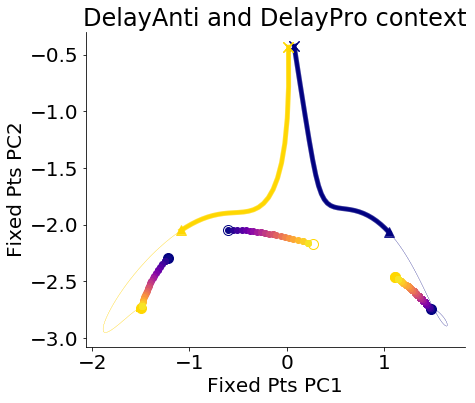

In [20]:
fig = plt.figure(figsize=(7,6),tight_layout=True,facecolor='white')
color_list = ['navy','gold']
t = 0
t_num = t
epoch_set = ['stim1','go1']
epoch = epoch_set[0]
rule = task_list[0]
n_interp = 20
n_fps_init = 60
step_file ='interp_tasks'
fp_epoch = 'fix1'

for ri in range(len(task_list)):
    ax1 = plt.subplot(1,1,1)
    
    rule_in = task_list[ri]
    rule_ic = task_list[opp[ri]]
    _, rule_in_name, _, _ = take_names(fp_epoch,rule_in)
    epoch_name, rule_ic_name, _, _ = take_names(fp_epoch,rule_ic)

    if ri%2==0:
        linestyle = '-'
        linestyle_opp = ':'
    else:
        linestyle = ':'
        linestyle_opp = '-'
    
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
    fp_struct = np.load(f)
    J_xstar = fp_struct['J_xstar']
    eig_decomps = comp_eig_decomp(J_xstar)
    sorted_fps = fp_struct['xstar']
    fp_inds = range(len(sorted_fps))
    qvals = fp_struct['qstar']
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,[rule_in,],
               rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
                   n_jit = 0,c_master = color_list[ri])

cmap_grad = plt.get_cmap('plasma')
# cmap_discrete = ['purple','gold']
# for ti in range(len(task_list)):
#     task = task_list[ti]
#     f = os.path.join(m_all,'tf_fixed_pts_all_init',task,fp_epoch+'_'+str(fp_t_num[ti])+'.0.npz')
#     fp_struct = np.load(f)
#     sorted_fps = fp_struct['xstar']
#     fp_project = np.dot(sorted_fps,D_use)
#     plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_discrete[ti],markersize = 10, alpha = .8)

for step_i in range(20):
    f = task_list[0]+'_'+task_list[1]+'_'+fp_epoch+'_'+str(t_num)+'_'+str(t_num)+'_step_'+str(step_i)
    filename = os.path.join(m_all,step_file,task_list[0]+'_'+task_list[1],f+'.npz')
    fp_struct = np.load(filename)
    step_fps = fp_struct['xstar']
    
    fp_project = np.dot(step_fps,D_use)
    plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_grad(step_i/20),label = 'step '+str(step_i))
    
plt.title(rule_in_name + ' and ' + rule_ic_name + ' '+epoch_name)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('Fixed Pts PC1')
plt.ylabel('Fixed Pts PC2')
# plt.legend(fontsize = 14)
# plt.ylim(-2,2)
# plt.xlim(-4,4)
    
figname = 'steps_'+axs+'_'+task_list[0]+'_'+task_list[1]+fp_epoch+str(fp_t_num[0])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,figname))
plt.show()

fdgo fix1 0 4.0
fdgo fix1 1 3.0
fdgo fix1 2 3.0
fdgo fix1 3 4.0


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return_n_iter=True)


fdgo fix1 4 2.0
fdgo stim1 0 5.0


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)


fdgo stim1 1 4.0
fdgo stim1 2 3.0
fdgo stim1 3 3.0
fdgo stim1 4 3.0
fdgo go1 0 3.0
fdgo go1 1 2.0
fdgo go1 2 2.0
fdgo go1 3 2.0
fdgo go1 4 3.0
fdanti fix1 0 4.0


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (66) found smaller than n_clusters (67). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (66) found smaller than n_clusters (68). Possibly due to duplicate points in X.
  return_n_iter=True)


fdanti fix1 1 2.0
fdanti fix1 2 4.0
fdanti fix1 3 3.0
fdanti fix1 4 2.0
fdanti stim1 0 5.0
fdanti stim1 1 4.0
fdanti stim1 2 3.0
fdanti stim1 3 4.0


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)


fdanti stim1 4 2.0
fdanti go1 0 2.0
fdanti go1 1 2.0
fdanti go1 2 2.0
fdanti go1 3 3.0
fdanti go1 4 2.0


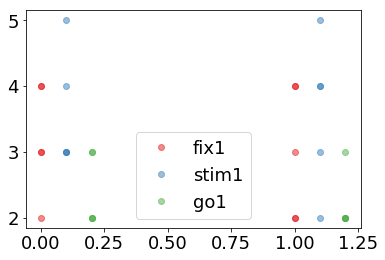

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist

num_fps = {}
num_fps['flat'] = []
n_models = 5
cmap = plt.get_cmap('Set1')
theta_list = [0,180]
epoch_list = ['fix1','stim1','go1']
for ri in range(len(task_list)):
    rule_in = task_list[ri]
    for ei in range(len(epoch_list)):
        fp_epoch = epoch_list[ei]
        num_fps[rule_in,fp_epoch] = np.zeros(n_models)
        for model_n in range(n_models):
            m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
            f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(theta_list[ri])+'.0.npz')
            fp_struct = np.load(f)
            
            X = euclidean_distances(fp_struct['xstar'])
            distortions = []
            K_max = np.shape(X)[0] 
            K = range(1,K_max)
            for k in K:
                kmeanModel = KMeans(n_clusters=k).fit(X)
                kmeanModel.fit(X)
                distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
            if (-np.diff(distortions)<.1).any():
                n_fps = np.min(np.where(-np.diff(distortions)<.1))+1
            else:
                n_fps = K_max

            num_fps[rule_in,fp_epoch][model_n] = int(n_fps)
            
            if len(num_fps['flat']) == 0:
                num_fps['flat'] = [int(n_fps),]
            else:
                num_fps['flat'] = np.concatenate((num_fps['flat'],[int(n_fps),]),axis = 0)
            print(rule_in,fp_epoch,model_n,num_fps[rule_in,fp_epoch][model_n])
    
        if ri==0:
            plt.plot(ri*np.ones(n_models)+ei*.1,num_fps[rule_in,fp_epoch],'o',
                     c = cmap((ei+1)/10),label = fp_epoch,alpha = .5)
        else:
            plt.plot(ri*np.ones(n_models)+ei*.1,num_fps[rule_in,fp_epoch],'o',
                     c = cmap((ei+1)/10),alpha = .5)
    plt.legend()

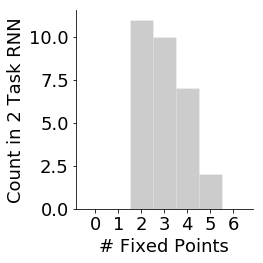

In [15]:
fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)
plt.hist(num_fps['flat'],np.linspace(-.5, max(num_fps['flat'])+1.5, max(num_fps['flat'])+3),
         alpha = .2, color = 'k',edgecolor='w')
plt.xlabel('# Fixed Points')
plt.ylabel('Count in 2 Task RNN')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(max(num_fps['flat'])+2))

figname = 'hist_num_fps.pdf'
plt.savefig(os.path.join(figpath,figname))
figname = 'hist_num_fps.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

go1
go1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/4/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/4/model.ckpt
80
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

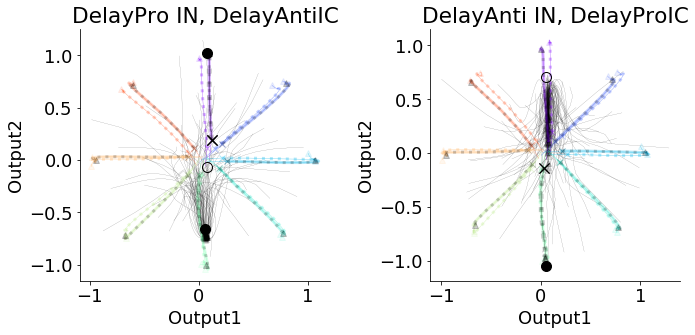

In [16]:
fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')
model_n = 2
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

for ri in range(len(task_list)):
    ax1 = plt.subplot(1,2,ri+1)
    
    rule_in = task_list[ri]
    rule_ic = task_list[opp[ri]]
    _, rule_in_name, _, _ = take_names(fp_epoch,rule_in)
    epoch_name, rule_ic_name, _, _ = take_names(fp_epoch,rule_ic)
    
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in,fp_epoch+'_'+str(fp_t_num[ri])+'.0.npz')
    fp_struct = np.load(f)
    J_xstar = fp_struct['J_xstar']
    eig_decomps = comp_eig_decomp(J_xstar)
    sorted_fps = fp_struct['xstar']
    fp_inds = range(len(sorted_fps))
    qvals = fp_struct['qstar']
    
    D_use = w_out[:,1:]
    
    plot_jitter_at_loc(m_all, rule_ic, rule_in, D_use, fp_epoch, t_num, 
                   rand_step_coef = rand_step_coef, n_steps = 50, n_jit = 1)
    plot_N_jitter(m_all,D_use,rule_ic,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = ':')
    plot_N_jitter(m_all,D_use,rule_in,fp_epoch,rand_step_coef = 0,n_steps = 100,n_jit = 1,
                   lw = 3,al = .3,linestyle = '-')
    
    plot_FP_jitter(m_all,D_use,rule_in,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,[rule_in,],
               rand_step_coef = rand_step_coef, al = al, linestyle = linestyle, n_steps = 100, 
                   n_jit = 0)
    
    tit = rule_in_name + ' IN, ' + rule_ic_name + 'IC'
    plt.title(tit)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.xlabel('Output1')
    plt.ylabel('Output2')
    
figname = 'Out_'+task_list[0]+'_'+task_list[1]+'stim'+str(fp_t_num[0])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [17]:
def make_X_steps_task(m, step_file, epoch, task_list, n_fps_init, t_num = 0, n_interp = 20):
    
    trial = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
    _,x1 = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    inds_use = [int(x) for x in np.linspace(T_inds[1],x1.shape[2]-1,n_interp)]
    h_tf = x1[:,:,inds_use]
    fp_steps = []

    for step_i in range(n_interp):
        n_fps = n_fps_init

        f = task_list[0]+'_'+task_list[1]+'_'+fp_epoch+'_'+str(t_num)+'_'+str(t_num)+'_step_'+str(step_i)
#         filename = os.path.join(m,step_file,epoch,task_list[0]+'_'+task_list[1],filename+'.npz')
        fp_struct = np.load(filename)

        sorted_fps = fp_struct['xstar']
        if np.shape(sorted_fps)[0]>n_fps:
            kmeans = KMeans(n_clusters=n_fps, random_state=0).fit(sorted_fps)
            _,fp_inds = np.unique(kmeans.labels_,return_index=True)
        else: 
            fp_inds = range(np.shape(sorted_fps)[0])

        n_fps = len(fp_inds)
        dst_FP = np.zeros((n_fps))
        for s in range(n_fps):
            dst_FP[s] = LA.norm(h_tf[:,t,step_i] - sorted_fps[fp_inds[s],:])

        sorted_inds = [fp_inds[int(x)] for x in np.argsort(dst_FP)]
        fps_sorted = sorted_fps[sorted_inds,:]

        if fp_steps == []:
            fp_steps = fps_sorted
            num_found = [np.shape(fps_sorted)[0],]
            qstar_vals = fp_struct['qstar'][sorted_inds]
        else:
            fp_steps = np.concatenate((fp_steps, fps_sorted), axis=0)
            num_found = num_found+ [np.shape(fps_sorted)[0],]
            qstar_vals = np.concatenate((qstar_vals,fp_struct['qstar'][sorted_inds]))
            
    X = np.squeeze(fp_steps).astype(np.float64)
    D = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    dst = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        for yi in range(np.shape(X)[0]):
            D[xi,yi] = LA.norm(X[xi,:]-X[yi,:])
            dst[xi,yi] = distance.euclidean(X[xi,:], X[yi,:])

    embedding = MDS(n_components = 2,dissimilarity = 'precomputed')
    X_steps = embedding.fit_transform(dst)
    
    return X_steps,dst,fp_steps,num_found,qstar_vals,X

In [18]:
def plot_h_mds_steps(X_transformed,n_interp,nfps,dot_alpha = .3):
    cmap=plt.get_cmap('plasma')
        
    for ri in range(n_interp):
        c = cmap(ri/n_interp)
        X_trial = X_transformed[(ri*nfps):((ri+1)*nfps),:]
        plt.plot(X_trial[:,0],X_trial[:,1],'o',c = c,alpha = dot_alpha,markersize = 10)

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

def plot_h_mds_steps_qstar(X_transformed,qstar_vals,size=200,dot_alpha = .3):
    
    cmap=plt.get_cmap('jet')
    plt.scatter(X_transformed[:,0],X_transformed[:,1],size,-np.log10(qstar_vals),alpha = dot_alpha,cmap='jet')

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

In [19]:
t = 0
t_num = t
epoch_set = ['stim1','go1']
epoch = epoch_set[0]
rule = task_list[0]
n_interp = 20
n_fps_init = 60
step_file ='interp_tasks'
# step_file ='fixed_pts_stepX_tasks_fwd_stim'
# step_file ='fixed_pts_stepX_tasks_fwd_large_init'

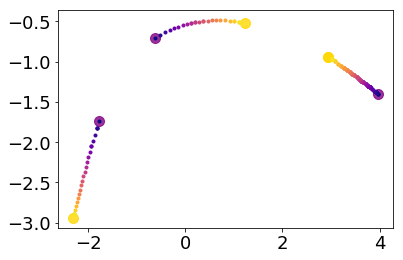

In [20]:
fp_t_num = [0,180]
fp_epoch = 'fix1'

f = os.path.join(m,'tf_fixed_pts_all_init',task_list[0],fp_epoch+'_'+str(fp_t_num[0])+'.0.npz')
D_use, sorted_fps, fp_inds = make_FP_axs(f,m_all,task_list[0],fp_epoch,n_fps = n_fps)

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['purple','gold']
for ti in range(len(task_list)):
    task = task_list[ti]
    f = os.path.join(m,'tf_fixed_pts_all_init',task,fp_epoch+'_'+str(fp_t_num[ti])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    fp_project = np.dot(sorted_fps,D_use)
    plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_discrete[ti],markersize = 10, alpha = .8)

for step_i in range(20):
    f = task_list[0]+'_'+task_list[1]+'_'+fp_epoch+'_'+str(t_num)+'_'+str(t_num)+'_step_'+str(step_i)
    filename = os.path.join(m,step_file,task_list[0]+'_'+task_list[1],f+'.npz')
    fp_struct = np.load(filename)
    step_fps = fp_struct['xstar']
    
    fp_project = np.dot(step_fps,D_use)
    plt.plot(fp_project[:,0],fp_project[:,1],'.',c = cmap_grad(step_i/20))

In [21]:
t_num = 0
epoch = 'fix1'
n_fps_init = 5
X_steps,D,fp_steps,num_found,qstar_vals,X = make_X_steps_task(m_all, step_file, epoch, task_list, n_fps_init, t_num = t_num, n_interp = 20)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/4/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/4/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Use

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [22]:
def plot_indep_fps(m,D,rule,fp_epoch,trial,c,add_zero = True):
    cmap=plt.get_cmap('plasma')
    
    if add_zero is True:
        filename = os.path.join(m,'tf_fixed_pts_all_init',rule,fp_epoch+'_'+str(trial)+'.0.npz')
    else:
        filename = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'_'+str(trial)+'.npz')

    print(filename)
    fp_struct = np.load(filename)
    fps = fp_struct['xstar']
    qs = fp_struct['qstar']

    X_steps = np.dot(fps,D)
    if isinstance(c, str):
        plt.scatter(X_steps[:,0],X_steps[:,1],150,c,edgecolors='k')
    else:
        plt.scatter(X_steps[:,0],X_steps[:,1],150,cmap(c*1000),edgecolors='k')
    return

In [23]:
def plot_steps_tasks(m, task_nums, X, qstar_vals, n_interp, n_fps, t_num = 0,  
                     plotN = False, plotN_epoch = 'delay1', plotIFPs = False, add_zero = True):

    linewidth = 3
    task_list = [rules_dict['all'][task_nums[0]], rules_dict['all'][task_nums[1]]]
    trial_set = range(0,80,10)
    t_num_list = [0,180]
    
    rule_axes = 'fdgo'
    f = os.path.join(m_all,'tf_fixed_pts_all_init',rule_axes,fp_epoch+'_'+str(fp_t_num[0])+'.0.npz')
    D, _, _ = make_FP_axs(f,m_all,rule_axes,'stim1',n_fps = n_fps,axs =axs,clust = 'False')
    w_in, b_in, w_out, b_out = get_model_params(m)
    D_go = w_out[:,1:]
    
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(2,2,1)
    X_steps = np.dot(X,D)
    
    
    if plotN:
        for sp in [1,3]:
            cmap=plt.get_cmap('rainbow')
            ax = plt.subplot(2,2,sp)
            
            trial1 = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
            _,x = gen_X_from_model_dir(m,trial1)
            T_inds = get_T_inds(trial1,plotN_epoch)
            x1 = np.transpose(x[:,:,T_inds],(1,2,0))
            s = 0
            c = cmap(0)
            X_trial = np.dot(x1[s,:,:],D)
            plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = .5)
            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = linewidth, alpha = .5)
            plt.plot(X_trial[0,0],X_trial[0,1],'.',c = c, linewidth = linewidth, alpha = .5)

            trial2 = same_stim_trial(trial1, task_nums[1])
            _,x = gen_X_from_model_dir(m,trial2)
            T_inds = get_T_inds(trial2,plotN_epoch)
            x2 = np.transpose(x[:,:,T_inds],(1,2,0))
            s = 40
            c = cmap(.5)
            X_trial = np.dot(x2[s,:,:],D)
            plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = .5)
            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = linewidth, alpha = .5)
            plt.plot(X_trial[0,0],X_trial[0,1],'.',c = c, linewidth = linewidth, alpha = .5)
            
            if plotIFPs:
                for task_num in range(2):
                    
                    if sp==3:
                        c = 'k'
                        plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
                    else:
                        c = task_num
                        plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
                        
                    plot_indep_fps(m,D,task_list[task_num],plotN_epoch,t_num_list[task_num],c,add_zero = add_zero)
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.xlabel('FP PC1',fontsize = 20)
            plt.ylabel('FP PC1',fontsize = 20)
            
            plt.ylim(-2,2)
            plt.xlim(-4,4)
    
    ax2 = plt.subplot(2,2,2)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
    if plotN:
        plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax2)
    legend_set = ['step '+ str(x) for x in range(1,21)]
    plt.legend((legend_set),bbox_to_anchor=(1.5, 1),fontsize = 11.9)

    ax4 = plt.subplot(2,2,4)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps_qstar(X_steps,qstar_vals,size = 30)
#     if plotN:
#         plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax4)
    axins = inset_axes(ax4,
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.2, -1.2, 1, .7),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

    cbar = plt.colorbar(cax = axins)
    cbar.set_label('-log10(qstar)',rotation = 90)
    return

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Use

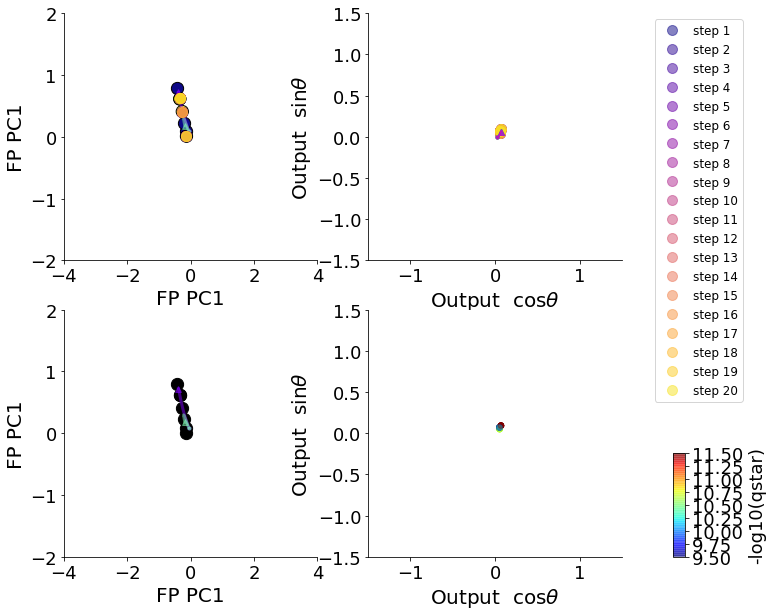

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,[0,3],X,qstar_vals,n_interp,n_fps,plotN = True, plotN_epoch = fp_epoch,
                plotIFPs = True, add_zero = True)
figname = task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [25]:
def plot_steps_tasks(m, task_nums, X, qstar_vals, n_interp, n_fps, t_num = 0,  
                     plotN = False, plotN_epoch = 'delay1', plotIFPs = False, add_zero = True):

    task_list = [rules_dict['all'][task_nums[0]], rules_dict['all'][task_nums[1]]]
    trial_set = range(0,80,10)
    t_num_list = [0,180]
    dot_alpha = .8
    marker_size = 100
    legend_set = ['step '+ str(x) for x in range(1,21)]
    
    D1 = make_axes(m,task_list[0],plotN_epoch,ind = -1)
    D2 = D1#make_axes(m,task_list[1],plotN_epoch,ind = -1)
    f = os.path.join(m,'tf_fixed_pts_all_init',task_list[0],plotN_epoch+'_'+str(t_num_list[0])+'.0.npz')
    D_fp, sorted_fps, fp_inds = make_FP_axs(f,m_all,task_list[0],plotN_epoch,n_fps = n_fps)
    D = D_fp
    w_in, b_in, w_out, b_out = get_model_params(m)
    D_go = w_out[:,1:]

    X_steps = np.dot(X,D)
    if plotN:
        for sp in [1,3]:
            
            fig = plt.figure(figsize=(4+sp/2, 5))
            ax = plt.subplot(1,1,1)
            
            if plotIFPs:
                for task_num in range(2):
                    
                    if sp==3:
                        c = 'k'
                        plot_h_mds_steps_qstar(X_steps,qstar_vals,dot_alpha = dot_alpha,size = marker_size)
                        if task_num==0:
                            cbar = plt.colorbar()
                            cbar.set_label('-log10(qstar)',rotation = 90)
                    else:
                        c = task_num
                        plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = dot_alpha)
                        plt.legend((legend_set),bbox_to_anchor=(1.01, 1),fontsize = 11)
                        
                    plot_indep_fps(m,D,task_list[task_num],plotN_epoch,t_num_list[task_num],c,add_zero = add_zero)
            
            trial1 = gen_trials_from_model_dir(m,task_list[0],noise_on = False)
            _,x = gen_X_from_model_dir(m,trial1)
            T_inds = get_T_inds(trial1,plotN_epoch)
            x1 = np.transpose(x[:,:,T_inds],(1,2,0))
            plot_N(x1[trial_set,:,:],D.T,trial1.y_loc[-1,trial_set])

            trial2 = same_stim_trial(trial1, task_nums[1])
            _,x = gen_X_from_model_dir(m,trial2)
            T_inds = get_T_inds(trial2,plotN_epoch)
            x2 = np.transpose(x[:,:,T_inds],(1,2,0))
            plot_N(x2[trial_set,:,:],D.T,trial2.y_loc[-1,trial_set])
            
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            plt.xlabel('FP PC1',fontsize = 20)
            plt.ylabel('FP PC1',fontsize = 20)
            
            if sp==3:
                figname = 'step_color_fpPC_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf'
            else:
                figname = 'q_color_fpPC_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf'
            
            plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
            plt.show()
    
    fig = plt.figure(figsize=(5, 5))
    x = plt.subplot(1,1,1)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = dot_alpha)
    if plotN:
        plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax)
    
    plt.legend((legend_set),bbox_to_anchor=(1.01, 1),fontsize = 11)
    figname = 'q_color_out_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf' 
    plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
    plt.show()

    fig = plt.figure(figsize=(5.5, 5))
    ax = plt.subplot(1,1,1)
    X_steps = np.dot(X,D_go)
    plot_h_mds_steps_qstar(X_steps,qstar_vals,dot_alpha = dot_alpha,size = marker_size)
#     if plotN:
#         plot_N(x1[trial_set,:,:],D_go.T,trial1.y_loc[-1,trial_set])
    out_axes(ax)

    cbar = plt.colorbar()#cax = axins)
    cbar.set_label('-log10(qstar)',rotation = 90)
    figname = 'q_color_out_'+task_list[0]+'_'+task_list[1]+'trial'+str(t_num)+'_fp_activity_overlay.pdf' 
    plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
    plt.show()
    return

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/tf_fixed_pts_all_init/fdanti/stim1_180.0.npz
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky

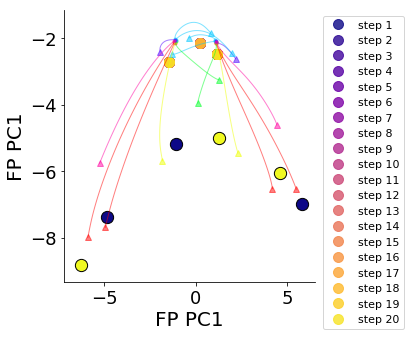

/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/tf_fixed_pts_all_init/fdgo/stim1_0.0.npz
/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/tf_fixed_pts_all_init/fdanti/stim1_180.0.npz
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/two_tasks/l2w0001_fdgo_fdanti/2/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky

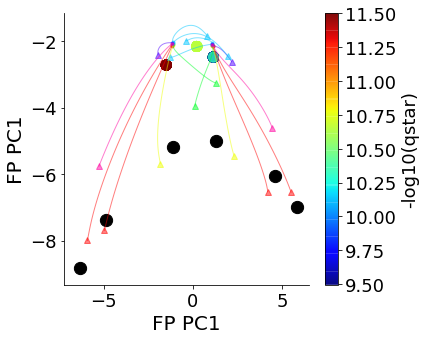

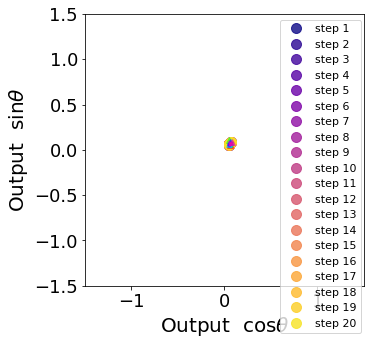

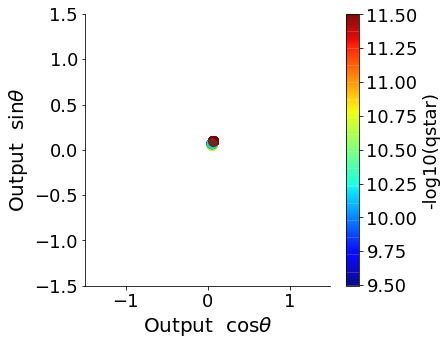

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
X = np.squeeze(fp_steps).astype(np.float64)
plot_steps_tasks(m,[0,3],X,qstar_vals,n_interp,n_fps,plotN = True, plotN_epoch = 'stim1',
                plotIFPs = True, add_zero = True)